# Online Learning Experiments - Group Project

This notebook contains all experiments for the Online Learning project, organized in a modular and scalable way.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Experiment Configuration Framework](#framework)
3. [Task 1.1: UCB1 Simple Pricing](#task1_1)
4. [Task 1.2: Constrained UCB Pricing](#task1_2)
5. [Task 2.1: Combinatorial UCB Multi-Product](#task2_1)
6. [Task 3.1: Primal-Dual Non-Stationary](#task3_1)
7. [Task 4.1: Multi-Product Primal-Dual](#task4_1)
8. [Task 5.1: Sliding Window Non-Stationarity](#task5_1)

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

print("Autoreload enabled - modules will be automatically reloaded when modified")

Autoreload enabled - modules will be automatically reloaded when modified


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')

from environments import *
from agents import *
from data_generators import *
from utils import *
from runner import *
from plotter import *
from scipy.stats import beta, truncnorm

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Setup completed successfully!")


Experiment framework created successfully!
Plotting and analysis utilities created successfully!
Setup completed successfully!


## <a id="task1_1"></a>Task 1.1: UCB1 Simple Pricing

Implementation of UCB1 for the pricing problem with uniform valuations.

Task 1.1 - UCB1 Simple Pricing
Prices: [0.2   0.256 0.311 0.367 0.422 0.478 0.553 0.589 0.644 0.7   0.756 0.811
 0.867 0.922 0.98  1.001]

=== Eseguendo esperimento con distribuzione Uniform ===
Running Task 1.1 - UCB1 Simple Pricing (Uniform)
Horizon: 20000, Trials: 3
Trial 1/3... Sell Probabilities: [ 0.8    0.744  0.689  0.633  0.578  0.522  0.447  0.411  0.356  0.3
  0.244  0.189  0.133  0.078  0.02  -0.001]
Expected Revenues: [ 0.16      0.190464  0.214279  0.232311  0.243916  0.249516  0.247191
  0.242079  0.229264  0.21      0.184464  0.153279  0.115311  0.071916
  0.0196   -0.001001]
Best price index: 5, Expected revenue: 0.249516
✓
Trial 2/3... Sell Probabilities: [ 0.8    0.744  0.689  0.633  0.578  0.522  0.447  0.411  0.356  0.3
  0.244  0.189  0.133  0.078  0.02  -0.001]
Expected Revenues: [ 0.16      0.190464  0.214279  0.232311  0.243916  0.249516  0.247191
  0.242079  0.229264  0.21      0.184464  0.153279  0.115311  0.071916
  0.0196   -0.001001]
Best price index: 5, E

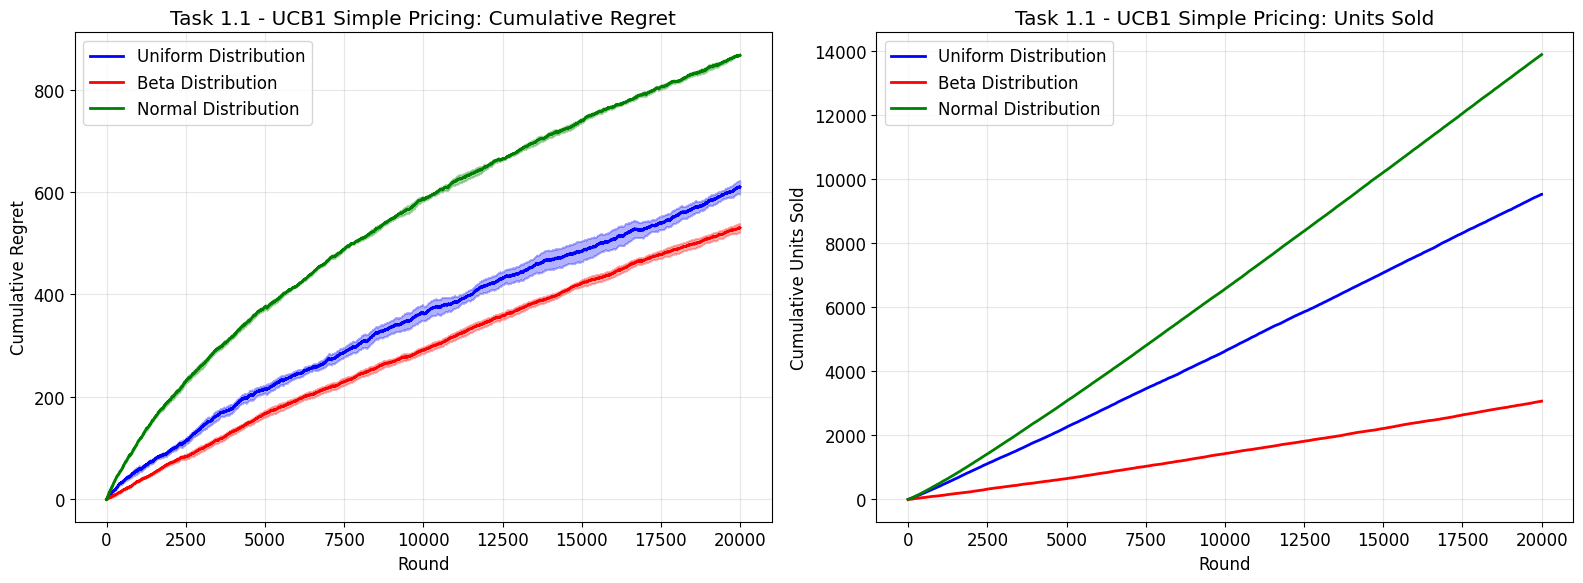


=== ANALISI DETTAGLIATA ===

--- Distribuzione Uniform ---

RESULTS FOR Task 1.1 - UCB1 Simple Pricing (Uniform)
Execution time: 0.42 seconds
Completed rounds: 20000
Average regret per round: 0.030482
Average final reward: 4380.69 ± 22.64
Efficiency vs clairvoyant: 87.8%
Average units sold: 9537.67/1000.0 (953.8%)
Empirical average rewards: [0.1597 0.1897 0.2118 0.2365 0.2422 0.251  0.2485 0.2413 0.2272 0.2137
 0.1679 0.1676 0.1173 0.0814 0.0152 0.    ]

--- Distribuzione Beta ---

RESULTS FOR Task 1.1 - UCB1 Simple Pricing (Beta)
Execution time: 0.46 seconds
Completed rounds: 20000
Average regret per round: 0.026500
Average final reward: 1035.78 ± 14.38
Efficiency vs clairvoyant: 66.2%
Average units sold: 3072.33/1000.0 (307.2%)
Empirical average rewards: [0.0714 0.0794 0.078  0.0768 0.0759 0.0549 0.0475 0.0434 0.036  0.0242
 0.023  0.0148 0.0074 0.0014 0.     0.    ]

--- Distribuzione Normal ---

RESULTS FOR Task 1.1 - UCB1 Simple Pricing (Normal)
Execution time: 0.46 seconds
Compl

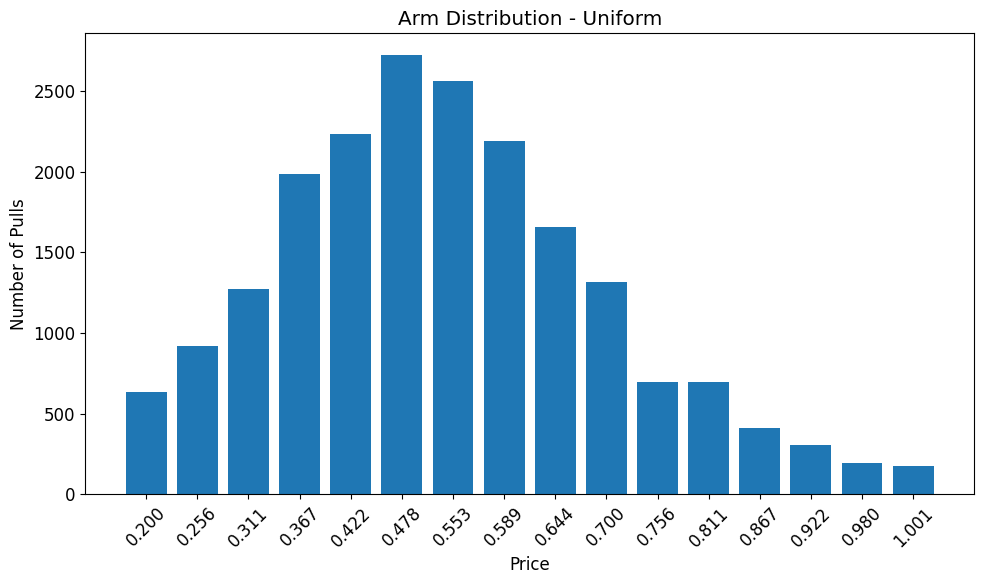

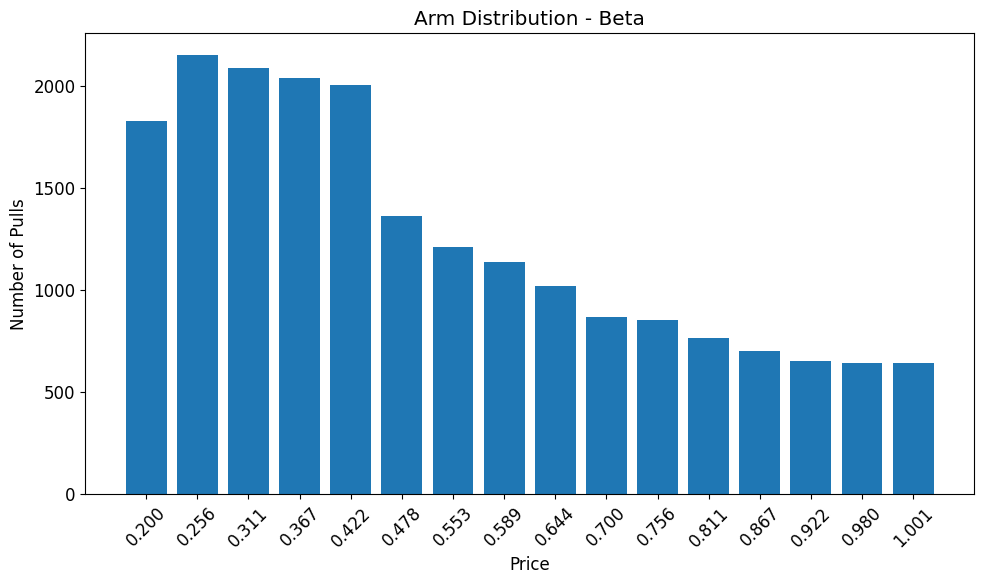

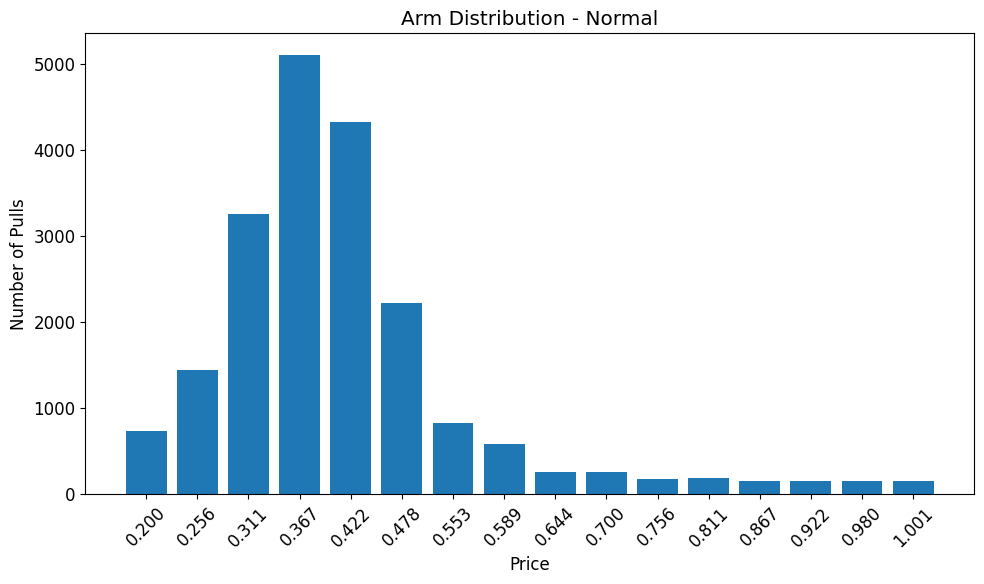

In [ ]:
class Task1_1_Runner(StandardExperimentRunner):
    """UCB1 Simple Pricing experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = PricingEnvironment(
            self.prices, self.config.horizon, rng=rng, distribution=self.distribution)
        return self.env

    def create_agent(self):
        self.agent = UCB1(len(self.prices), self.config.horizon)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        if self.distribution == Distribution.UNIFORM:
            self.probabilities = 1 - self.prices
        elif self.distribution == Distribution.BETA:
            self.probabilities = 1 - beta.cdf(self.prices, 0.5, 2)
        elif self.distribution == Distribution.NORMAL:
            
            mu, sigma = 0.5, 0.15
            a, b = (0.0 - mu) / sigma, (1.0 - mu) / sigma
            dist = truncnorm(a, b, loc=mu, scale=sigma)
            self.probabilities = 1.0 - dist.cdf(self.prices)
        else:
            raise ValueError(f"Distribution {self.distribution} not supported")
        print(f"Sell Probabilities: {self.probabilities}")
        self.expected_revenues = self.prices * self.probabilities
        print(f"Expected Revenues: {self.expected_revenues}")
        self.best_idx = np.argmax(self.expected_revenues)
        print(f"Best price index: {self.best_idx}, Expected revenue: {self.expected_revenues[self.best_idx]}")
        self.clairvoyant_reward_per_round = self.expected_revenues[self.best_idx]

        return self.clairvoyant_reward_per_round

    def extract_metrics(self, result) -> tuple[float, float]:
        
        reward = float(result) if not isinstance(result, tuple) else float(result[0])
        units = 1.0 if reward > 0.0 else 0.0
        return reward, units



price_grid = create_default_prices()
config = ExperimentConfig(
    task_name="Task 1.1 - UCB1 Simple Pricing",
    horizon=20_000,
    n_trials=3,
    seed=18,
    prices=price_grid,
    distribution=[Distribution.UNIFORM, Distribution.BETA , Distribution.NORMAL]  
)

print(f"Task 1.1 - UCB1 Simple Pricing")
print(f"Prices: {price_grid}")

# Esegui gli esperimenti
multi_runner = MultiDistributionRunner(Task1_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=False)

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## <a id="task1_2"></a>Task 1.2: Constrained UCB Pricing

Implementation of Constrained UCB for pricing with budget constraints.


Task 1.2 - Constrained UCB Pricing
Prices: 11 prices from 0.100 to 1.000
Budget: 10000, Horizon: 20000

=== Eseguendo esperimento con distribuzione Beta ===
Running Task 1.2 - Constrained UCB Pricing (Beta)
Horizon: 20000, Trials: 3
Trial 1/3... Sell Probabilities Beta : [8.85735e-01 6.55360e-01 4.20175e-01 2.33280e-01 1.09375e-01 4.09600e-02
 1.09350e-02 1.60000e-03 5.50000e-05 0.00000e+00 0.00000e+00]
Expected Revenues Beta : [8.857350e-02 1.310720e-01 1.260525e-01 9.331200e-02 5.468750e-02
 2.457600e-02 7.654500e-03 1.280000e-03 4.950000e-05 0.000000e+00
 0.000000e+00]
Expected utility: 0.1278
Optimal distribution (gamma): [0.         0.33941365 0.66058635 0.         0.         0.
 0.         0.         0.         0.         0.        ]
Expected cost: 0.5000
✓
Trial 2/3... Sell Probabilities Beta : [8.85735e-01 6.55360e-01 4.20175e-01 2.33280e-01 1.09375e-01 4.09600e-02
 1.09350e-02 1.60000e-03 5.50000e-05 0.00000e+00 0.00000e+00]
Expected Revenues Beta : [8.857350e-02 1.310720e-01 

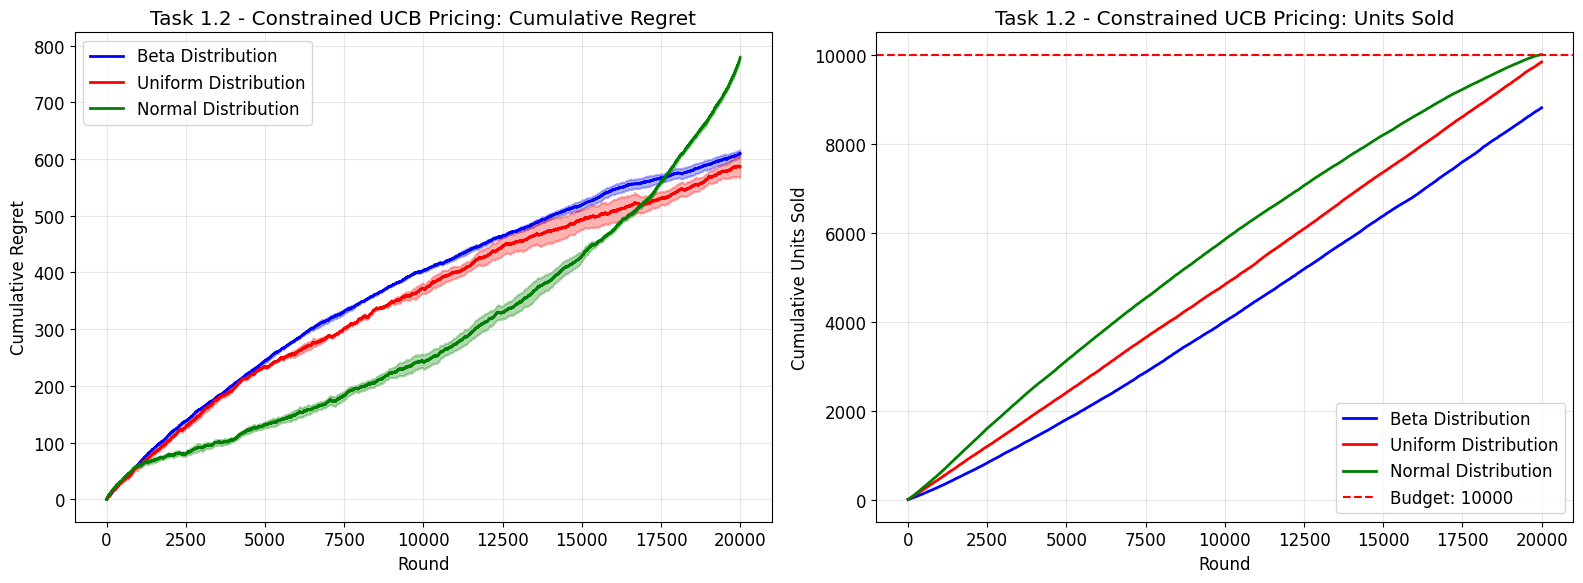


=== ANALISI DETTAGLIATA ===

--- Distribuzione Beta ---

RESULTS FOR Task 1.2 - Constrained UCB Pricing (Beta)
Execution time: 134.62 seconds
Completed rounds: 20000
Average regret per round: 0.030470
Average final reward: 1945.73 ± 12.36
Efficiency vs clairvoyant: 76.2%
Average units sold: 8804.67/10000 (88.0%)

--- Distribuzione Uniform ---

RESULTS FOR Task 1.2 - Constrained UCB Pricing (Uniform)
Execution time: 134.97 seconds
Completed rounds: 20000
Average regret per round: 0.029332
Average final reward: 4413.37 ± 32.99
Efficiency vs clairvoyant: 88.3%
Average units sold: 9834.67/10000 (98.3%)

--- Distribuzione Normal ---

RESULTS FOR Task 1.2 - Constrained UCB Pricing (Normal)
Execution time: 131.96 seconds
Completed rounds: 20000
Average regret per round: 0.038945
Average final reward: 4221.10 ± 9.17
Efficiency vs clairvoyant: 84.4%
Average units sold: 10000.00/10000 (100.0%)

=== CONFRONTO FINALE ===
Beta: Final Average Regret = 609.3904, Final Average Reward = 1945.7333
Unif

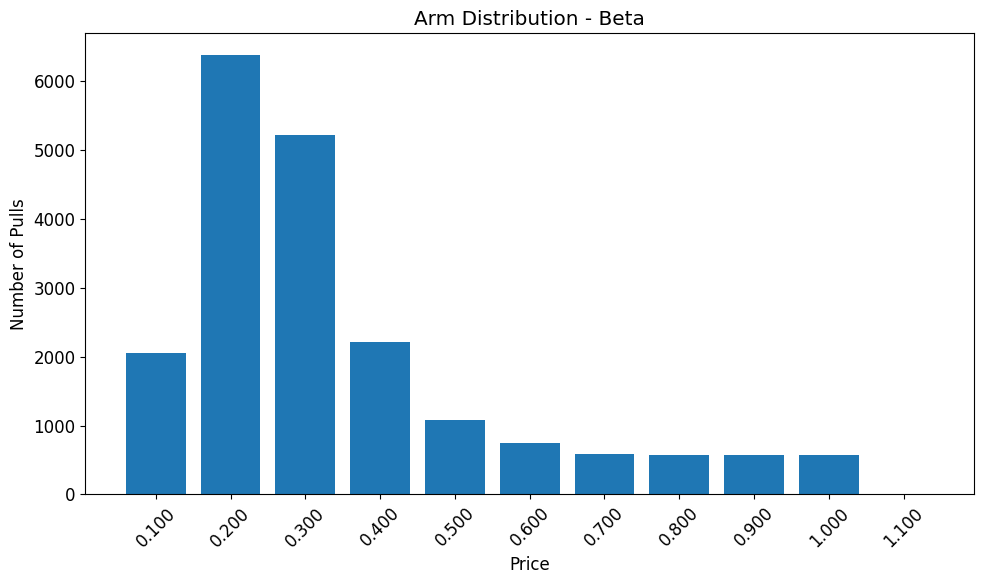

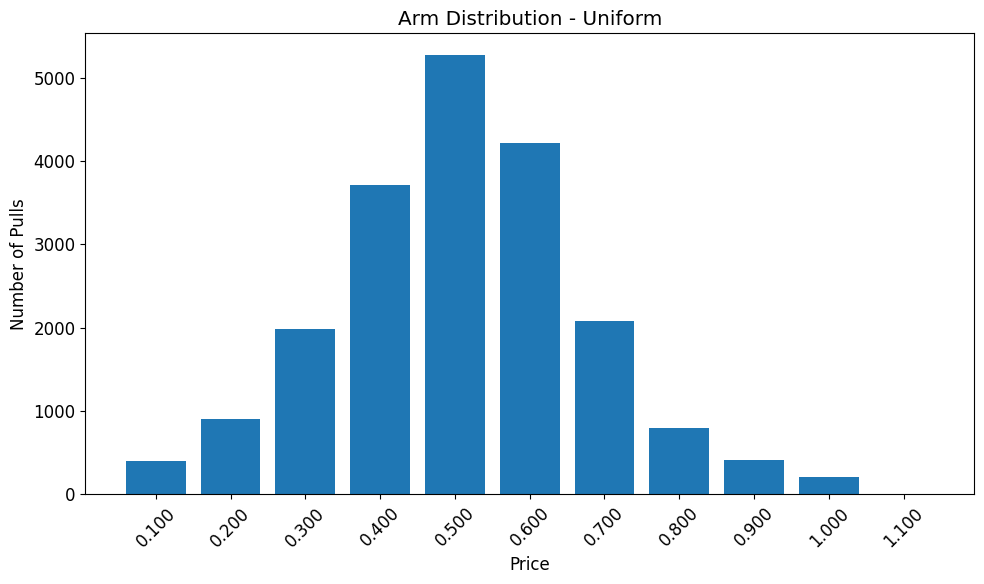

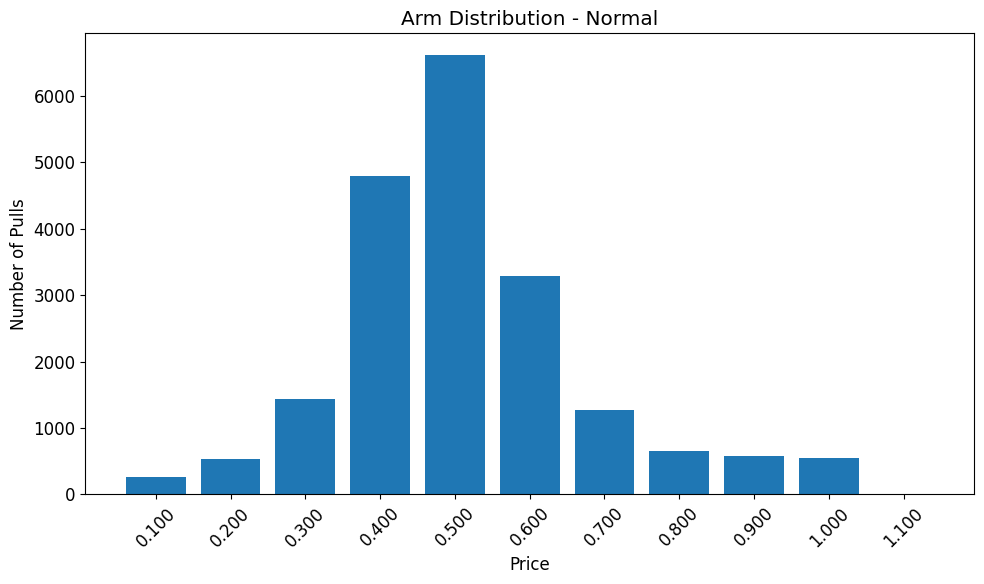

In [ ]:
class Task1_2_Runner(StandardExperimentRunner):
    """Constrained UCB Pricing experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.distribution = config.distribution
        self.adaptive_rho = config.adaptive_rho

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = BudgetedPricingEnvironment(
            self.prices, self.config.horizon, rng=rng, distribution=self.distribution)
        return self.env

    def create_agent(self):
        self.agent = UCBBudget(
            len(self.prices), self.config.budget, self.config.horizon, alpha=2, adaptive_rho=self.adaptive_rho)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        if self.distribution == Distribution.UNIFORM:
            self.sell_probabilities = np.maximum(0, 1 - self.prices)
            print(f"Sell Probabilities Uniform : {self.sell_probabilities}")
            print(
                f"Expected Revenues Uniform : {self.prices * self.sell_probabilities}")
        elif self.distribution == Distribution.BETA:
            self.sell_probabilities = 1 - beta.cdf(self.prices, 2, 5)
            print(f"Sell Probabilities Beta : {self.sell_probabilities}")
            print(
                f"Expected Revenues Beta : {self.prices * self.sell_probabilities}")
        elif self.distribution == Distribution.NORMAL:
            
            mu, sigma = 0.5, 0.15
            a, b = (0.0 - mu) / sigma, (1.0 - mu) / sigma
            dist = truncnorm(a, b, loc=mu, scale=sigma)
            self.sell_probabilities = 1.0 - dist.cdf(self.prices)
            print(f"Sell Probabilities Normal : {self.sell_probabilities}")
            print(f"Expected Revenues Normal : {self.prices * self.sell_probabilities}")
        else:
            raise ValueError(f"Distribution {self.distribution} not supported")

        self.expected_reward = self.prices * self.sell_probabilities
        self.exp_util, self.gamma, self.exp_cost = compute_clairvoyant_single_product(
            self.prices, self.sell_probabilities, self.config.budget, self.config.horizon)

        return self.exp_util

    def extract_metrics(self, result) -> tuple[float, float]:
        return float(result[0]), float(result[1])


price_grid = np.concatenate([np.linspace(0.1, 1.0, 10), [1.1]])
config = ExperimentConfig(
    task_name="Task 1.2 - Constrained UCB Pricing",
    horizon=20_000,
    n_trials=3,
    seed=18,
    budget=10_000,
    prices=price_grid,
    distribution=[Distribution.BETA, Distribution.UNIFORM, Distribution.NORMAL],
    adaptive_rho=True
)

print("Task 1.2 - Constrained UCB Pricing")
print(
    f"Prices: {len(price_grid)} prices from {price_grid[0]:.3f} to {price_grid[-2]:.3f}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")

multi_runner = MultiDistributionRunner(Task1_2_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True)

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## <a id="task2_1"></a>Task 2.1: Combinatorial UCB Multi-Product

Implementation of Constrained Combinatorial UCB for multi-product pricing with shared budget.


Price grid: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Task 2.1 - Combinatorial UCB Multi-Product
Products: 3, Prices per product: 10
Budget: 70000, Horizon: 40000

=== Eseguendo esperimento con distribuzione Beta ===
Running Task 2.1 - Combinatorial UCB Multi-Product (Beta)
Horizon: 40000, Trials: 1
Trial 1/1... f_true: [array([0.094703, 0.14764 , 0.138849, 0.092715, 0.044922, 0.015021,
       0.003004, 0.000251, 0.000003, 0.      , 0.      ]), array([0.099077, 0.174032, 0.17526 , 0.111703, 0.044891, 0.010506,
       0.001166, 0.000037, 0.      , 0.      , 0.      ]), array([0.099973, 0.195344, 0.245409, 0.19511 , 0.089821, 0.021137,
       0.001976, 0.00004 , 0.      , 0.      , 0.      ])]
c_true: [array([0.947028, 0.738198, 0.462831, 0.231787, 0.089844, 0.025035,
       0.004291, 0.000314, 0.000003, 0.      , 0.      ]), array([0.99077 , 0.87016 , 0.584201, 0.279257, 0.089783, 0.01751 ,
       0.001666, 0.000046, 0.      , 0.      , 0.      ]), array([0.999727, 0.976722, 0.81803 , 0

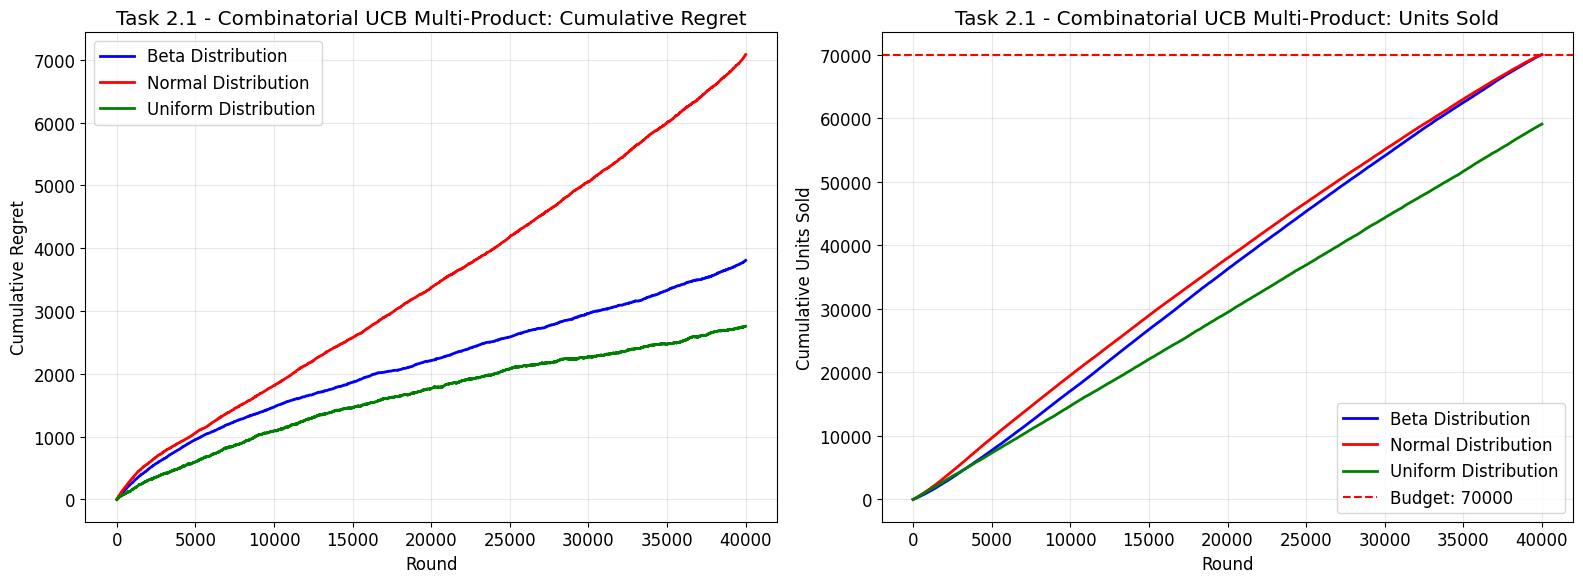


=== ANALISI DETTAGLIATA ===

--- Distribuzione Beta ---

RESULTS FOR Task 2.1 - Combinatorial UCB Multi-Product (Beta)
Execution time: 57.62 seconds
Completed rounds: 40000
Average regret per round: 0.095184
Average final reward: 17872.40 ± 0.00
Efficiency vs clairvoyant: 82.4%
Average units sold: 70000.00/70000 (100.0%)

--- Distribuzione Normal ---

RESULTS FOR Task 2.1 - Combinatorial UCB Multi-Product (Normal)
Execution time: 57.93 seconds
Completed rounds: 40000
Average regret per round: 0.177070
Average final reward: 22741.20 ± 0.00
Efficiency vs clairvoyant: 76.3%
Average units sold: 69999.00/70000 (100.0%)

--- Distribuzione Uniform ---

RESULTS FOR Task 2.1 - Combinatorial UCB Multi-Product (Uniform)
Execution time: 57.09 seconds
Completed rounds: 40000
Average regret per round: 0.068910
Average final reward: 27243.60 ± 0.00
Efficiency vs clairvoyant: 90.8%
Average units sold: 59067.00/70000 (84.4%)

=== CONFRONTO FINALE ===
Beta: Final Average Regret = 3807.3749, Final Avera

<Figure size 1000x600 with 0 Axes>

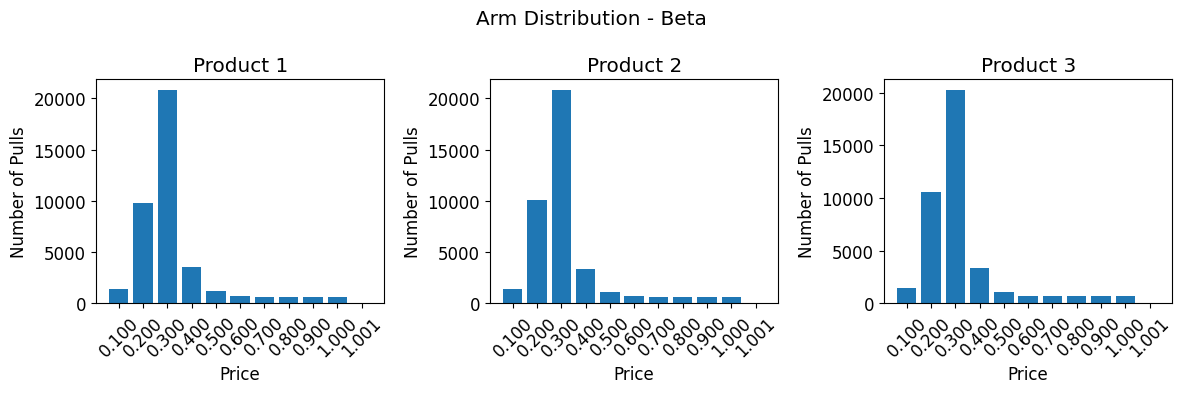

<Figure size 1000x600 with 0 Axes>

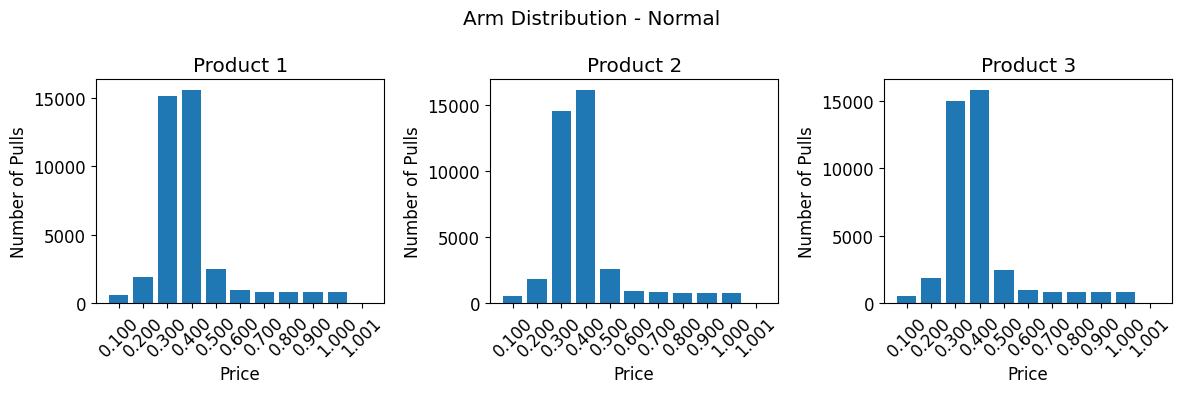

<Figure size 1000x600 with 0 Axes>

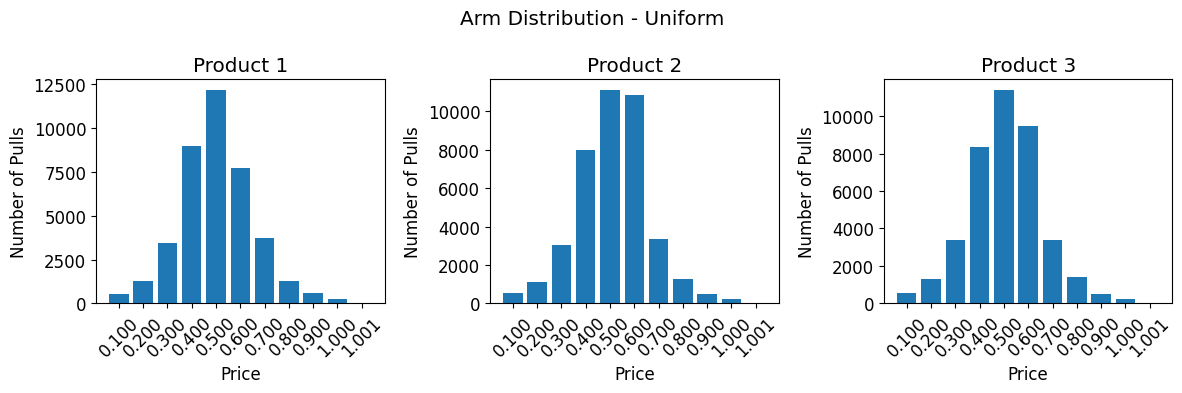

In [ ]:
class Task2_1_Runner(StandardExperimentRunner):
    """Combinatorial UCB Multi-Product experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.distribution = config.distribution
        self.price_grid = [np.concatenate([config.prices, [1.001]]) for _ in range(self.n_products)]
        self.adaptive_rho = config.adaptive_rho
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = MultiProductPricingEnvironment(self.price_grid, self.config.horizon, rng=rng, distribution=self.distribution)
        return self.env
        
    def create_agent(self):
        self.agent = ConstrainedCombinatorialUCBAgent(self.price_grid, self.config.budget, self.config.horizon, alpha=2, adaptive_rho=self.adaptive_rho)
        return self.agent
        
    
    def compute_clairvoyant_reward(self) -> float:
        """
        Allows per-product heterogeneity while keeping the same public API.
        If self.distribution == UNIFORM/BETA/NORMAL, we still use that family,
        but apply 3 different parameter settings, cycled across products.

        Optionally, you can define these attributes on `self`:
        - self.uniform_params = [(low, high), (low, high), (low, high)]
        - self.beta_params    = [(a, b), (a, b), (a, b)]
        - self.normal_params  = [(mu, sigma), (mu, sigma), (mu, sigma)]
        If not provided, defaults below are used.
        """
        N = len(self.price_grid)

        
        uniform_params = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
        beta_params    = [(3.0, 7.0), (5.0, 10.0), (8.0, 12.0)]
        normal_params  = [(0.35, 0.08), (0.45, 0.10), (0.55, 0.12)]

        f_true, c_true = [], []

        if self.distribution == Distribution.UNIFORM:
            for j, prices in enumerate(self.price_grid):
                low, high = uniform_params[j % 3]
                denom = (high - low)
                tail = np.where(denom > 0, (high - prices) / denom, 0.0)
                tail = np.clip(tail, 0.0, 1.0)
                c_true.append(tail)
                f_true.append(prices * tail)

        elif self.distribution == Distribution.BETA:
            for j, prices in enumerate(self.price_grid):
                a, b = beta_params[j % 3]
                tail = 1.0 - beta.cdf(prices, a, b)   # P(v >= p)
                c_true.append(tail)
                f_true.append(prices * tail)

        elif self.distribution == Distribution.NORMAL:
            for j, prices in enumerate(self.price_grid):
                mu, sigma = normal_params[j % 3]
                a, b = (0.0 - mu) / sigma, (1.0 - mu) / sigma
                dist = truncnorm(a, b, loc=mu, scale=sigma)
                tail = 1.0 - dist.cdf(prices)         # P(v >= p)
                tail = np.clip(tail, 0.0, 1.0)        
                c_true.append(tail)
                f_true.append(prices * tail)

        else:
            raise ValueError(f"Distribution {self.distribution} not supported")

        print(f"f_true: {f_true}")
        print(f"c_true: {c_true}")
        self.clair_reward, self.simplex = solve_clairvoyant_lp(
            self.price_grid, self.config.budget, self.config.horizon, f_true, c_true
        )
        return self.clair_reward

        
    def extract_metrics(self, result) -> tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))

n_products = 3
price_grid = np.linspace(0.1, 1.0, 10)
print(f"Price grid: {price_grid}")

config = ExperimentConfig(
    task_name="Task 2.1 - Combinatorial UCB Multi-Product",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=20_000,
    prices=price_grid,
    n_products=n_products,
    distribution=[Distribution.BETA , Distribution.NORMAL , Distribution.UNIFORM], 
    adaptive_rho=True
)

print(f"Task 2.1 - Combinatorial UCB Multi-Product")
print(f"Products: {n_products}, Prices per product: {len(price_grid)}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")

multi_runner = MultiDistributionRunner(Task2_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## <a id="task3_1"></a>Task 3.1: Primal-Dual Non-Stationary Pricing

Implementation of Full-Feedback Primal-Dual for non-stationary environments with adversarial shocks.


In [ ]:
class Task3_1_Runner(StandardExperimentRunner):
    """Primal-Dual Non-Stationary Pricing experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.shock_prob = 0.05 
        self.freq = 50
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = NonStationaryBudgetedPricingEnvironment(
            self.prices, self.config.horizon, self.shock_prob, self.freq,num_regimes=int(config.horizon / 4), distribution=self.distribution, rng=rng
        )
        return self.env

    def create_agent(self):
        eta = 1 / np.sqrt(self.config.horizon)
        
        self.agent = FFPrimalDualPricingAgent(
            self.prices, self.config.horizon, self.config.budget, eta=eta)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        """Compute clairvoyant reward - override for specific tasks"""
        sell_probabilities = self.env.compute_sell_probabilities()
        exp_util, gamma, exp_cost = compute_clairvoyant_single_product(
            self.prices, sell_probabilities, self.config.budget, self.config.horizon
        )

        return exp_util

price_grid = create_default_prices()
config = ExperimentConfig(
    task_name="Task 3.1 - Primal-Dual Non-Stationary Pricing",
    horizon=20_000,
    n_trials=1,
    seed=17,
    budget=6_000,
    prices=price_grid,
    distribution=[Distribution.BETA, Distribution.UNIFORM_SINUSOIDAL, Distribution.PIECEWISE_BETA]
)

print(f"Task 3.1 - Primal-Dual Non-Stationary Pricing")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Shock probability: {0.50}, Frequency: {300}")
print(f"Prices: {len(price_grid)} from {price_grid[0]:.3f} to {price_grid[-2]:.3f}")

multi_runner = MultiDistributionRunner(Task3_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

print(f"\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 3.1 - Lambda (λ) Over Time - {name}")
    
    StandardPlotter.plot_hedge_probabilities(
        result.final_agents[0], title=f"Task 3.1 - Hedge Probabilities Over Time - {name}")

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## <a id="task3_2"></a>Task 3.2: Primal-Dual Non-Stationary Pricing

Implementation of Full-Feedback Primal-Dual for non-stationary environments with adversarial shocks.


In [ ]:
class Task3_2_Runner(StandardExperimentRunner):
    """Primal-Dual Non-Stationary Pricing experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.shock_prob = 0.05
        self.freq = 50
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = NonStationaryBudgetedPricingEnvironment(
            self.prices, self.config.horizon, self.shock_prob, self.freq,
            num_regimes= int(self.config.horizon / 4), rng=rng, distribution=self.distribution
        )
        return self.env

    def create_agent(self):
        self.agent = BanditFeedbackPrimalDual(
            self.prices, self.config.horizon, self.config.budget)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        """Compute clairvoyant reward - override for specific tasks"""
        sell_probabilities = self.env.compute_sell_probabilities()
        exp_util, gamma, exp_cost = compute_clairvoyant_single_product(
            self.prices, sell_probabilities, self.config.budget, self.config.horizon
        )
        return exp_util

price_grid = create_default_prices()
config = ExperimentConfig(
    task_name="Task 3.2 - Primal-Dual Non-Stationary Pricing",
    horizon=100_000,
    n_trials=1,
    seed=17,
    budget=30_000,
    prices=price_grid,
    distribution=[Distribution.BETA, Distribution.UNIFORM_SINUSOIDAL, Distribution.PIECEWISE_BETA]
)

print(f"Task 3.2 - Primal-Dual Non-Stationary Pricing")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Shock probability: {0.50}, Frequency: {300}")
print(f"Prices: {len(price_grid)} from {price_grid[0]:.3f} to {price_grid[-2]:.3f}")

multi_runner = MultiDistributionRunner(Task3_2_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

print(f"\n=== PLOT FOR EACH DISTRIBUTION ===")
for name, result in results.items():
    print(f"\nPlot for distribution {name}:")

    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 3.2 - Lambda (λ) Over Time - {name}")
    
    if hasattr(result.final_agents[0], 'hedge_weight_history'):
        StandardPlotter.plot_hedge_probabilities(
            result.final_agents[0], title=f"Task 3.2 - Hedge Probabilities Over Time - {name}")
    else:
        print(f"Hedge probabilities not available for {name} (Bandit Feedback)")

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## Task 4.1: Multi-Product Primal-Dual Hedge

Implementation of Multi-Product Full-Feedback Primal-Dual for correlated multi-product with Hedge


Task 4.1 - Multi-Product Primal-Dual
Products: 4, Budget: 8000, Horizon: 10000
Prices: 16 from 0.200 to 0.980
Correlation parameters: μ₀=0.5, ρ₀=0.6

=== Eseguendo esperimento con distribuzione Simple TV ===
Running Task 4.1 - Multi-Product Primal-Dual (Simple TV)
Horizon: 10000, Trials: 1
Trial 1/1... Expected utility: 0.4830
Optimal distribution (gamma): [[ 0.         0.         0.         0.         0.         0.
   0.         1.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.
   0.         0.6037464  0.3962536  0.         0.         0.
   0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.
   0.         1.        -0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.
   0.        -0.         1.         0.  

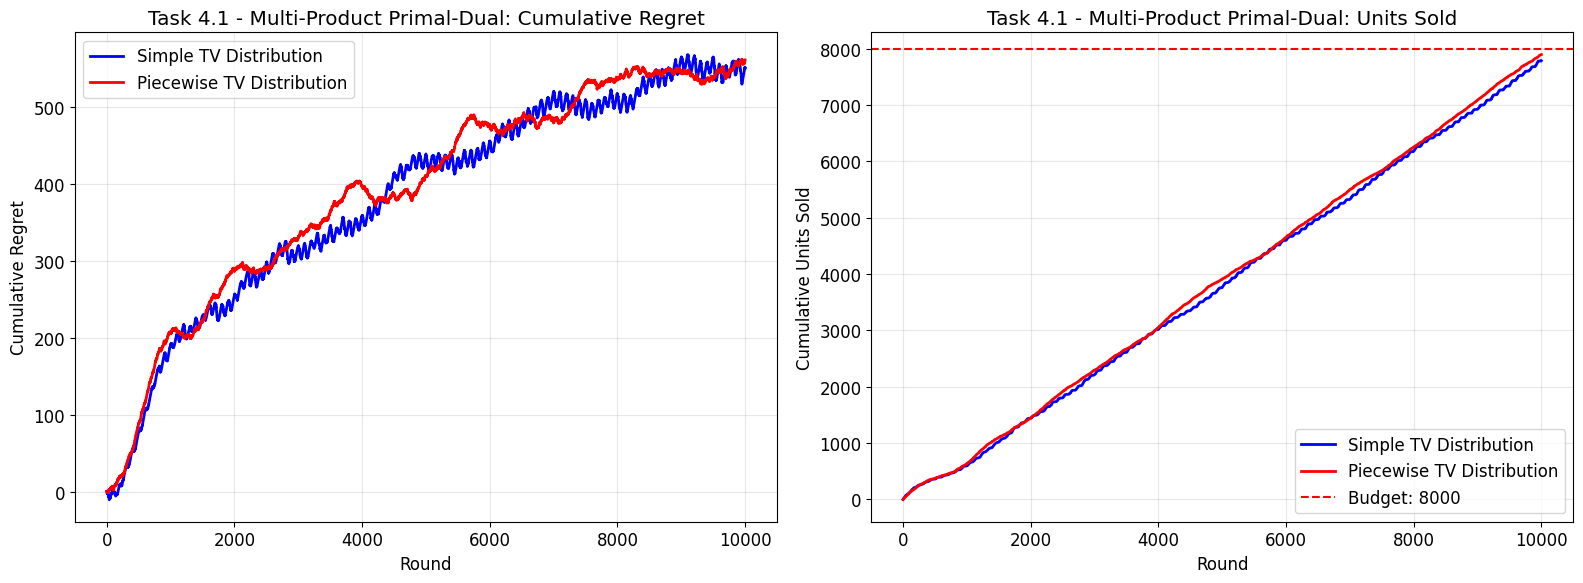


=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===

Plot per distribuzione Simple TV:


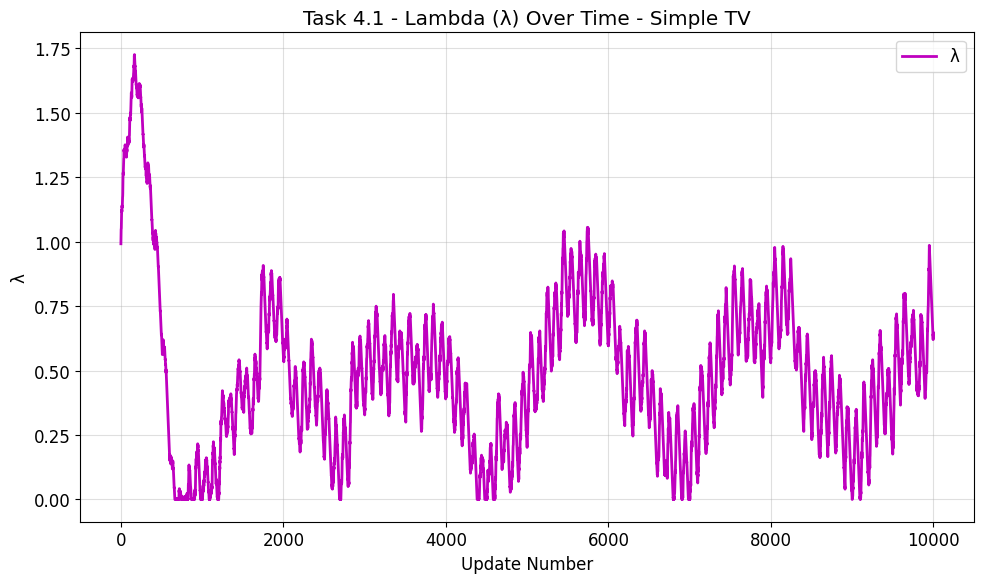

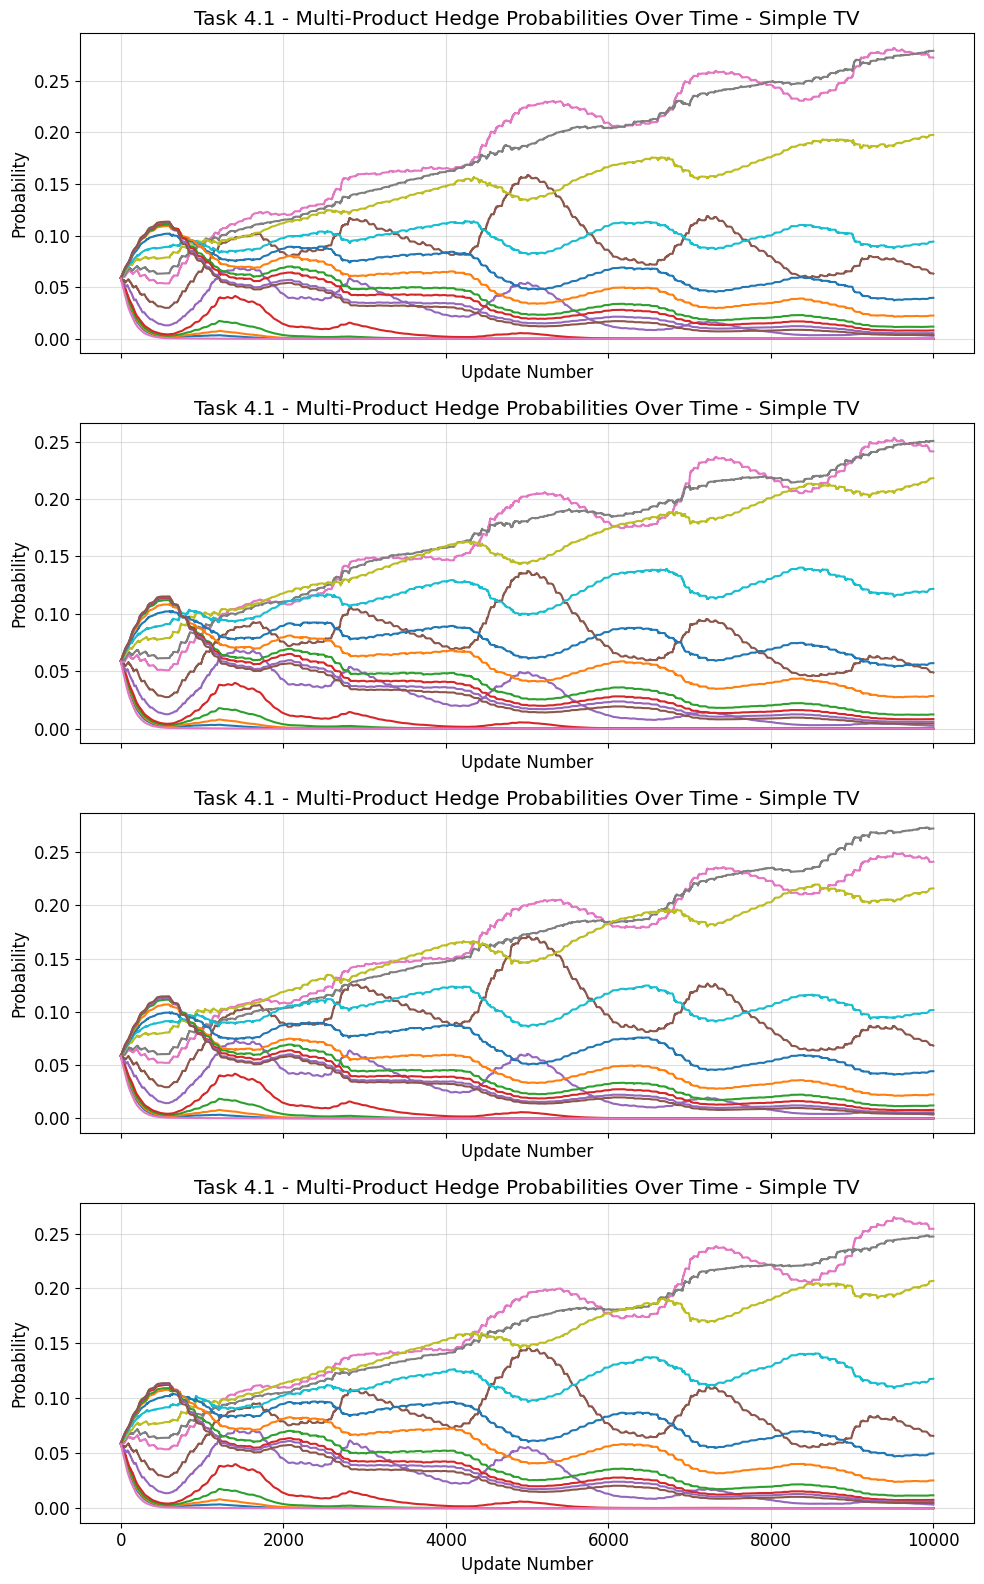


Plot per distribuzione Piecewise TV:


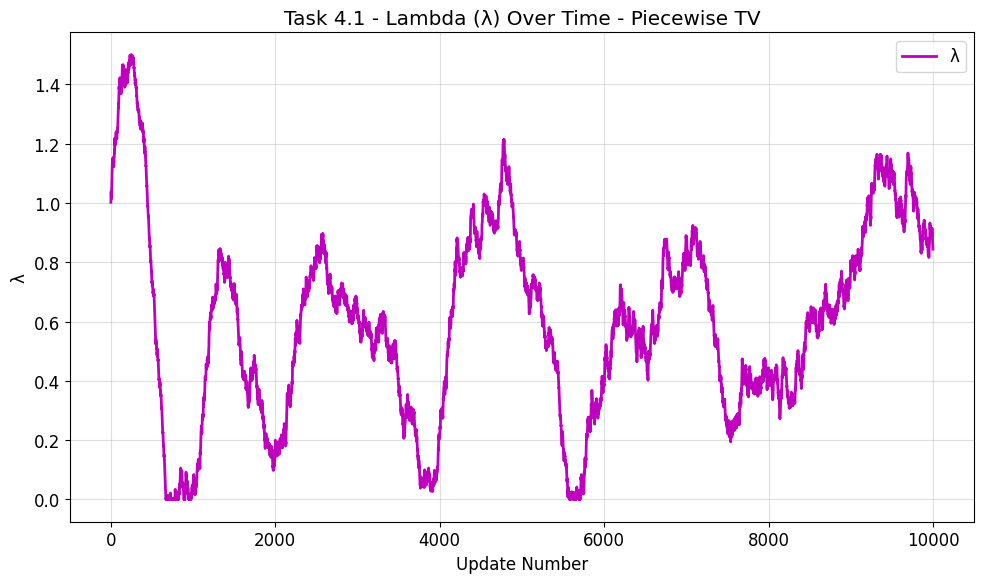

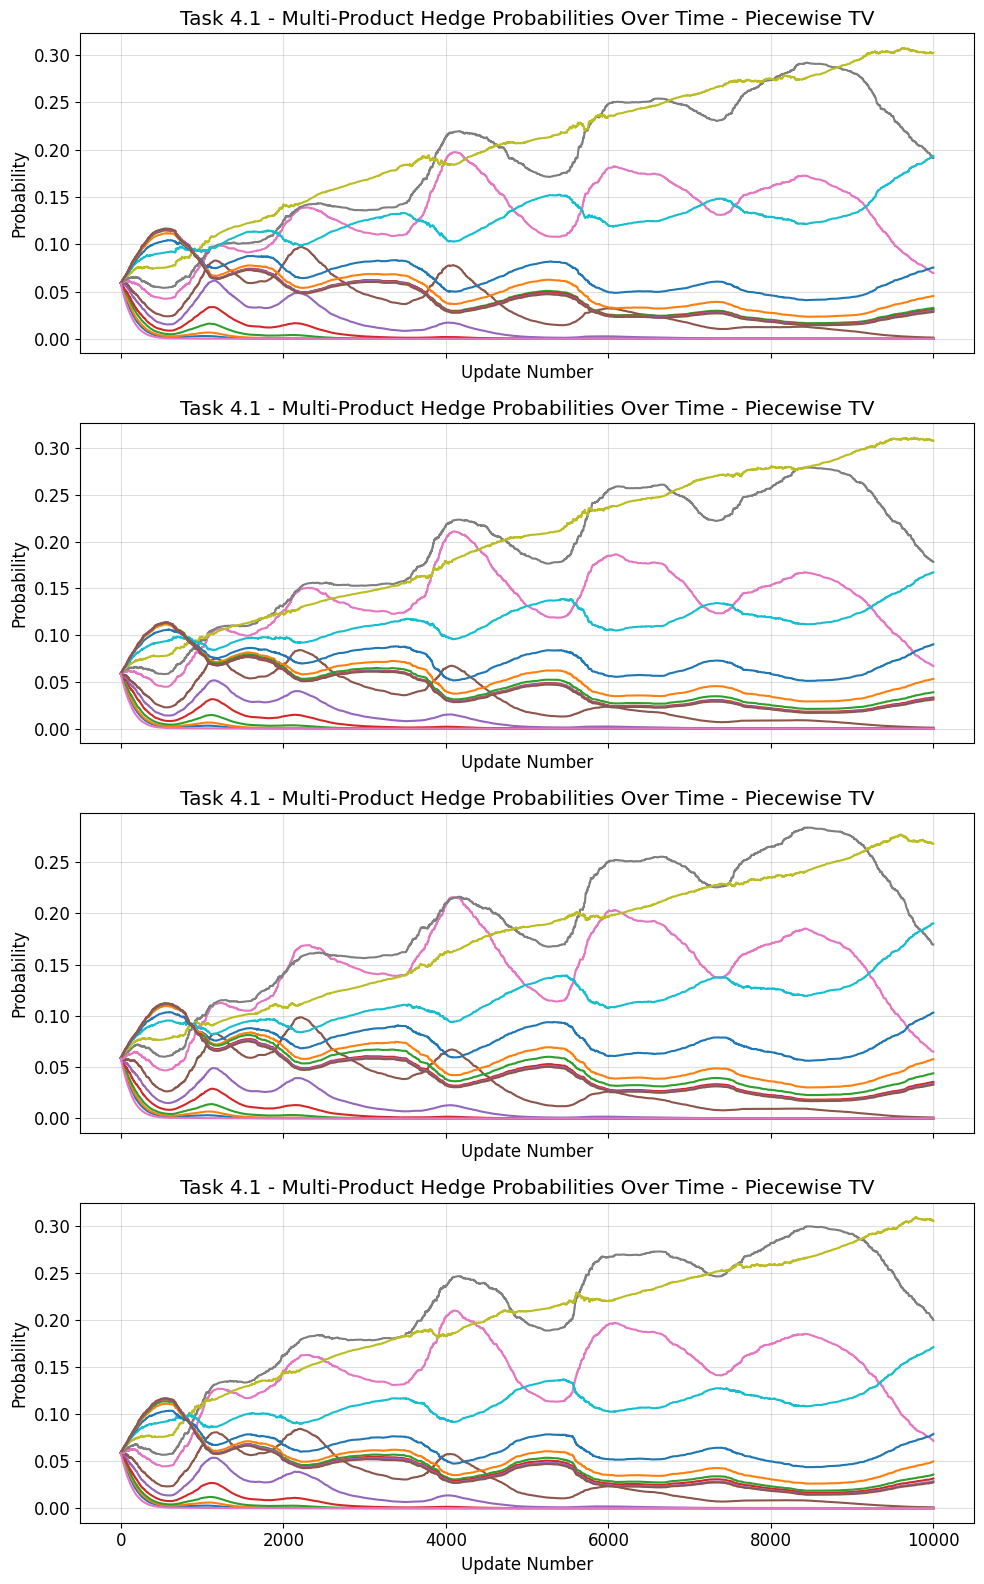


=== ANALISI DETTAGLIATA ===

--- Distribuzione Simple TV ---

RESULTS FOR Task 4.1 - Multi-Product Primal-Dual (Simple TV)
Execution time: 2.88 seconds
Completed rounds: 10000
Average regret per round: 0.055031
Average final reward: 4279.80 ± 0.00
Efficiency vs clairvoyant: 88.6%
Average units sold: 7789.00/8000 (97.4%)

--- Distribuzione Piecewise TV ---

RESULTS FOR Task 4.1 - Multi-Product Primal-Dual (Piecewise TV)
Execution time: 2.71 seconds
Completed rounds: 10000
Average regret per round: 0.056095
Average final reward: 4515.24 ± 0.00
Efficiency vs clairvoyant: 88.9%
Average units sold: 7898.00/8000 (98.7%)

=== CONFRONTO FINALE ===
Simple TV: Final Average Regret = 550.3083, Final Average Reward = 4279.8050
Piecewise TV: Final Average Regret = 560.9508, Final Average Reward = 4515.2400


In [ ]:
class Task4_1_Runner(StandardExperimentRunner):
    """Multi-Product Primal-Dual experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.n_products)
        ]
        self.distribution = config.distribution
        
        self.phi = 0.0
        self.mu0, self.A, self.f = 0.5, 0.1, 100
        self.sigma0, self.A_sigma, self.phi_sigma, self.rho0 = 0.1, 0.1, 0, 0.6

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        valuation_params = {
            'mu0': self.mu0, 'A': self.A, 'f': self.f, 'phi': self.phi,
            'sigma0': self.sigma0, 'A_sigma': self.A_sigma, 'phi_sigma': self.phi_sigma, 'rho0': self.rho0,
            'num_regimes': self.config.horizon // 4 #each last for 4 steps to simulate non-stationarity
        }
        self.env = MultiProductBudgetedPricingEnvironment(self.config.horizon, self.n_products, valuation_params, distribution=self.distribution, rng=rng)
        return self.env

    def create_agent(self) -> MultiProductFFPrimalDualPricingAgent:
        eta = 1 / np.sqrt(self.config.horizon)
        self.agent = MultiProductFFPrimalDualPricingAgent(self.price_grid, self.config.horizon, self.config.budget, self.n_products, eta)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        exp_util, gamma, exp_cost = compute_extended_clairvoyant(
            self.env.valuations, self.price_grid[0], self.config.budget)
        return exp_util

prices = create_default_prices()
config = ExperimentConfig(
    task_name="Task 4.1 - Multi-Product Primal-Dual",
    horizon=10_000,
    n_trials=1,
    seed=42,
    budget=8_000,
    prices=prices,
    n_products=4,
    distribution=[Distribution.SIMPLE_TV, Distribution.PIECEWISE_TV]
)

print(f"Task 4.1 - Multi-Product Primal-Dual")
print(f"Products: 4, Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices: {len(prices)} from {prices[0]:.3f} to {prices[-2]:.3f}")
print(f"Correlation parameters: μ₀=0.5, ρ₀=0.6")

multi_runner = MultiDistributionRunner(Task4_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

print(f"\n=== PLOT FOR EACH DISTRIBUTION ===")
for name, result in results.items():
    print(f"\nPlot for distribution {name}:")

    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 4.1 - Lambda (λ) Over Time - {name}")
    
    StandardPlotter.plot_multi_hedge_probabilities(
        result.final_agents[0], 
        title=f"Task 4.1 - Multi-Product Hedge Probabilities Over Time - {name}")

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## Task 4.2: Multi-Product Primal-Dual Exp3.P

Implementation of Multi-Product Full-Feedback Primal-Dual for correlated multi-product with Exp3.P

In [ ]:
class Task4_2_Runner(StandardExperimentRunner):
    """Multi-Product Primal-Dual experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.n_products)
        ]
        self.distribution = config.distribution

        self.phi = 0.0
        self.mu0, self.A, self.f = 0.5, 0.1, 100
        self.sigma0, self.A_sigma, self.phi_sigma, self.rho0 = 0.1, 0.1, 0, 0.6

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        valuation_params = {
            'mu0': self.mu0, 'A': self.A, 'f': self.f, 'phi': self.phi,
            'sigma0': self.sigma0, 'A_sigma': self.A_sigma, 'phi_sigma': self.phi_sigma, 'rho0': self.rho0,
            'num_regimes': self.config.horizon // 4
        }
        self.env = MultiProductBudgetedPricingEnvironment(
            self.config.horizon, self.n_products, valuation_params, distribution=self.distribution, rng=rng, price_grid=self.price_grid
        )
        return self.env

    def create_agent(self) -> MultiProductPDExp3PricingAgent:
        eta = 1 / np.sqrt(self.config.horizon)
        self.agent = MultiProductPDExp3PricingAgent(
            self.price_grid, self.config.horizon, self.config.budget, self.n_products, eta)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        exp_util, gamma, exp_cost = compute_extended_clairvoyant(
            self.env.valuations, self.price_grid[0], self.config.budget)
        return exp_util

prices = create_default_prices()
config = ExperimentConfig(
    task_name="Task 4.2 - Multi-Product Primal-Dual",
    horizon=10_000,
    n_trials=1,
    seed=42,
    budget=9_000,
    prices=prices,
    n_products=3,
    distribution=[Distribution.PIECEWISE_TV, Distribution.SIMPLE_TV]
)

print(f"Task 4.2 - Multi-Product Primal-Dual")
print(f"Products: {config.n_products}, Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices: {len(prices)} from {prices[0]:.3f} to {prices[-2]:.3f}")
print(f"Correlation parameters: μ₀=0.5, ρ₀=0.6")

multi_runner = MultiDistributionRunner(Task4_2_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

print(f"\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 4.2 - Lambda (λ) Over Time - {name}")
    
    if hasattr(result.final_agents[0], 'hedge_prob_history'):
        StandardPlotter.plot_multi_hedge_probabilities(
            result.final_agents[0], 
            title=f"Task 4.2 - Multi-Product Hedge Probabilities Over Time - {name}")
    else:
        print(f"Multi-hedge probabilities non disponibili per {name} (EXP3.P Bandit Feedback)")

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## Task 5.1: Sliding Window per Non-Stazionarietà Weak Baseline

Implementation of Constrained Combinatorial UCB with Sliding Window for local adaptation to new window's distribution.


Task 5.1 - Sliding Multi-Product Pricing
Products: 3, Temporal windows: 5
Budget: 30000, Horizon: 20000
Prices per product: 11

=== Eseguendo esperimento con distribuzione Smooth Similar ===
Running Task 5.1 - Sliding Multi-Product Pricing (Smooth Similar)
Horizon: 20000, Trials: 1
Trial 1/1... Expected utility: 0.6258
Optimal distribution (gamma): [[ 0.        0.        0.        0.707516  0.292484  0.        0.
   0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        1.        0.        0.
   0.        0.        0.        0.      ]
 [ 0.        0.        0.       -0.        1.        0.        0.
   0.        0.        0.        0.      ]]
Expected cost: 1.5000
Trial 1: Agent stopped at round 15841. ✓
Expected utility: 0.6258
Optimal distribution (gamma): [[ 0.        0.        0.        0.707516  0.292484  0.        0.
   0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        1.        0.        0.
   0.        0.        0.   

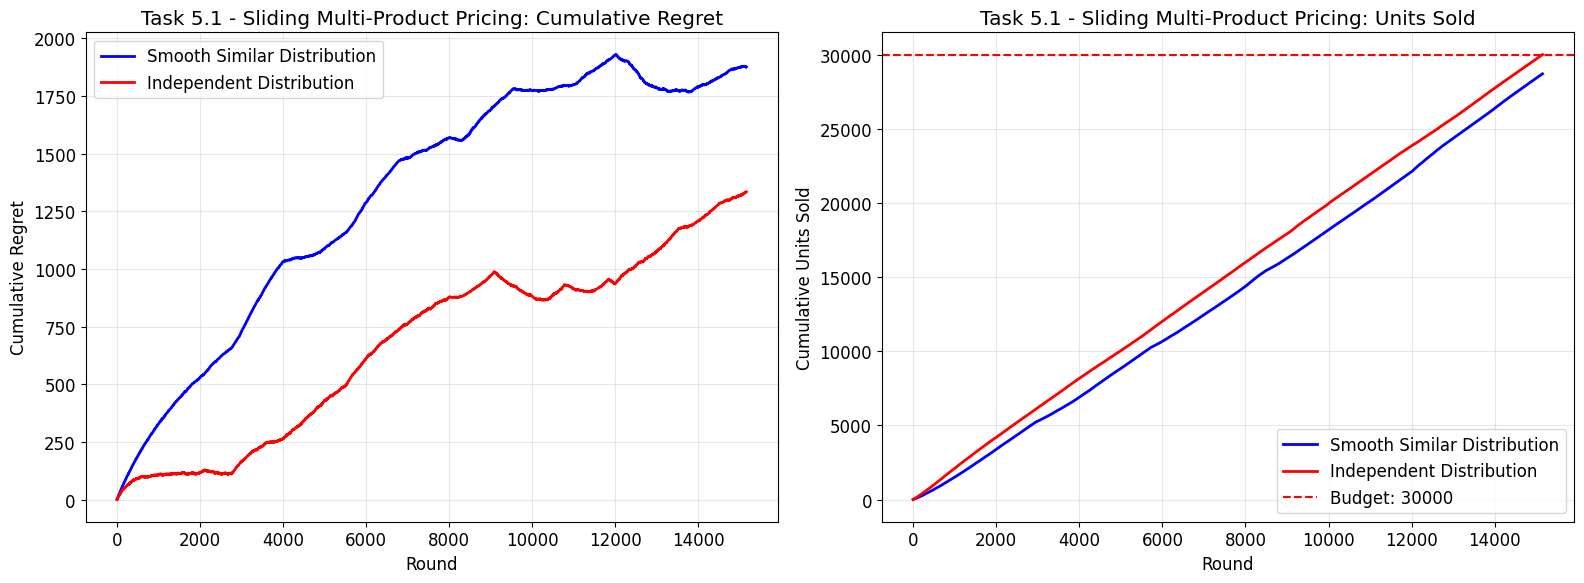


=== ANALISI DETTAGLIATA ===

--- Distribuzione Smooth Similar ---

RESULTS FOR Task 5.1 - Sliding Multi-Product Pricing (Smooth Similar)
Execution time: 45.44 seconds
Completed rounds: 15841
Average regret per round: 0.115731
Average final reward: 8080.00 ± 0.00
Efficiency vs clairvoyant: 81.5%
Average units sold: 30000.00/30000 (100.0%)

--- Distribuzione Independent ---

RESULTS FOR Task 5.1 - Sliding Multi-Product Pricing (Independent)
Execution time: 42.81 seconds
Completed rounds: 15154
Average regret per round: 0.088026
Average final reward: 11503.11 ± 0.00
Efficiency vs clairvoyant: 89.6%
Average units sold: 30001.00/30000 (100.0%)

=== CONFRONTO FINALE ===
Smooth Similar: Final Average Regret = 1833.2940, Final Average Reward = 8080.0000
Independent: Final Average Regret = 1333.9512, Final Average Reward = 11503.1111


In [31]:
class Task5_1_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.N_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.N_products)
        ]
        self.num_windows = config.n_windows
        self.window_size = int(
            (config.horizon * np.log(config.horizon)) ** (2/3))
        self.window_size = config.horizon // self.num_windows
        self.window_size = config.horizon ** (4/5)
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, rng=rng, 
            distribution=self.distribution, n_products=self.N_products, 
            num_windows=self.num_windows
        )
        return self.env

    def create_agent(self):
        self.agent = SlidingWindowConstrainedCombinatorialUCBAgent(
            self.price_grid, self.config.budget, self.config.horizon,
            window_size=self.window_size
        )
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        full_prices = self.price_grid[0]
        self.clairvoyant_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.env.valuations, full_prices, self.config.budget
        )
        return self.clairvoyant_reward

    def extract_metrics(self, result) -> Tuple[float, float]:
        rewards, costs, _ = result
        return float(np.sum(rewards)), float(np.sum(costs))

    def run_single_trial(self, trial: int) -> Tuple[List[float], List[int], float, Any]:
        """Run a single trial and return regrets, units sold, final reward, and final agent"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)

        self.env = self.create_environment(trial_seed)
        self.agent = self.create_agent()

        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0.0

        clairvoyant_reward = self.compute_clairvoyant_reward()

        for t in range(self.config.horizon):
            action = self.agent.pull_arm()

            if action is None:
                print(f"Trial {trial+1}: Agent stopped at round {t}.", end=" ")
                break

            rewards, costs, _ = self.env.round(action)

            self.agent.update(rewards, costs)

            reward, cost = float(np.sum(rewards)), float(np.sum(costs))

            cum_reward += reward
            cum_units += cost

            instant_regret = clairvoyant_reward - reward
            cum_regret += instant_regret

            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        return regrets, units_sold, cum_reward, self.agent


base_prices = np.linspace(0, 1, 10)

config = ExperimentConfig(
    task_name="Task 5.1 - Sliding Multi-Product Pricing",
    horizon=20_000,
    n_trials=1,
    seed=18,
    budget=30_000,
    prices=base_prices,
    n_products=3,
    n_windows=5,
    distribution=[Distribution.SMOOTH_SIMILAR_STEP, Distribution.SMOOTH_INDEPENDENT_STEP]
)

print(f"Task 5.1 - Sliding Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: {config.n_windows}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

multi_runner = MultiDistributionRunner(Task5_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True)

multi_runner.print_analysis()

## Task 5.1: Sliding Window per Non-Stazionarietà Strong Baseline


Implementation of Constrained Combinatorial UCB with Sliding Window for local adaptation to new window's distribution.


Task 5.1 - Sliding Multi-Product Pricing
Products: 3, Temporal windows: 5
Budget: 30000, Horizon: 20000
Prices per product: 11

=== Eseguendo esperimento con distribuzione Smooth Similar ===
Running Task 5.1 - Sliding Multi-Product Pricing (Smooth Similar)
Horizon: 20000, Trials: 1
Trial 1/1... Expected cost: 1.5000
Optimal expected revenue per round: 0.5002
Optimal distribution (simplex): [0.       0.       0.       1.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.994705 0.005295
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       1.       0.       0.       0.       0.       0.       0.
 0.      ]
f_true: [array([0.      , 0.111106, 0.208585, 0.135146, 0.015016, 0.000203,
       0.      , 0.      , 0.      , 0.      , 0.      ]), array([0.      , 0.111111, 0.221937, 0.293988, 0.148103, 0.012775,
       0.000094, 0.      , 0.      , 0.      , 0.      ]), array([0.      , 0.111054, 0.185513, 0.071834, 0.004034, 0.00

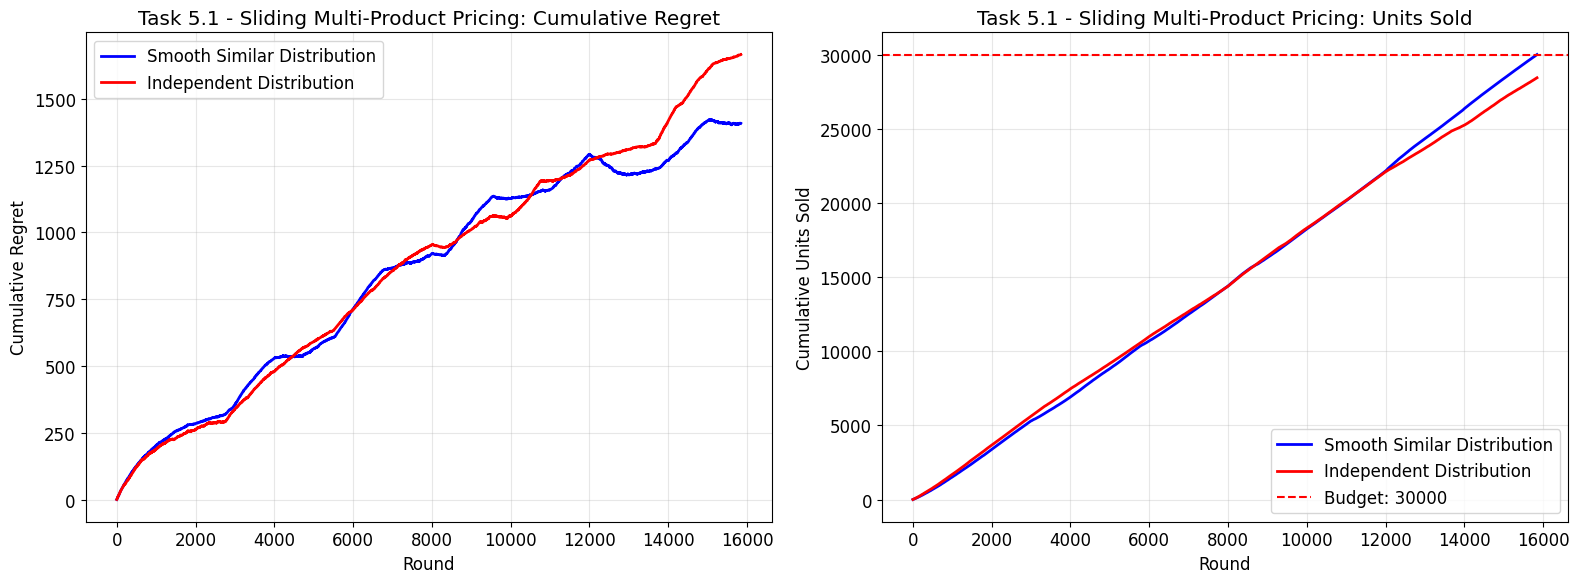

15843

In [ ]:
class Task5_1_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.N_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.N_products)
        ]
        self.num_windows = config.n_windows
        self.window_size = int(
            (config.horizon * np.log(config.horizon)) ** (2/3))
        self.window_size = config.horizon // self.num_windows
        self.window_size = config.horizon ** (4/5)
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, rng=rng, 
            distribution=self.distribution, n_products=self.N_products, 
            num_windows=self.num_windows
        )
        return self.env

    def create_agent(self):
        self.agent = SlidingWindowConstrainedCombinatorialUCBAgent(
            self.price_grid, self.config.budget, self.config.horizon,
            window_size=self.window_size
        )
        return self.agent

    
    def compute_clairvoyant_reward(self) -> List[float]:
        """
        Compute per-window clairvoyant rewards using the true expected means
        from the data generator (no need to re-estimate from samples).
        """
        full_prices = self.price_grid[0]
        horizon = self.config.horizon
        num_windows = self.num_windows
        L = horizon // num_windows
        remaining_budget = self.config.budget
        concentration = self.env.concentration  

        expected_means = self.env.expected_means  
        assert expected_means.shape == self.env.valuations.shape

        rewards_per_window = []

        for k in range(num_windows):
            start = k * L
            end = horizon if k == num_windows - 1 else (k + 1) * L
            duration = end - start
            means_window = expected_means[start]  # all values in the window are the same

            f_true, c_true = [], []
            for j, prices in enumerate(self.price_grid):
                mu = means_window[j]
                a = mu * concentration
                b = (1 - mu) * concentration

                tail = 1.0 - beta.cdf(prices, a, b)
                tail = np.clip(tail, 0.0, 1.0)

                c_true.append(tail)
                f_true.append(prices * tail)
            window_budget = min(remaining_budget, self.config.budget * (duration / self.config.horizon))
            opt_reward, simplex = solve_clairvoyant_lp(
                self.price_grid, window_budget, duration, f_true, c_true
            )
            expected_cost = np.sum(np.concatenate(c_true) * simplex)
            rewards_per_window.append(opt_reward * duration)
            # Update remaining budget
            remaining_budget -= expected_cost * duration

        return rewards_per_window


    def extract_metrics(self, result) -> Tuple[float, float]:
        rewards, costs, _ = result
        return float(np.sum(rewards)), float(np.sum(costs))

    def run_single_trial(self, trial: int) -> Tuple[List[float], List[int], float, Any]:
        """Run a single trial and return regrets, units sold, final reward, and final agent"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)

        self.env = self.create_environment(trial_seed)
        self.agent = self.create_agent()

        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0.0

        clairvoyant_rewards = self.compute_clairvoyant_reward()
        L = self.config.horizon // self.num_windows
        

        for t in range(self.config.horizon):
            action = self.agent.pull_arm()

            if action is None:
                print(f"Trial {trial+1}: Agent stopped at round {t}.", end=" ")
                break

            rewards, costs, _ = self.env.round(action)

            self.agent.update(rewards, costs)

            reward, cost = float(np.sum(rewards)), float(np.sum(costs))

            cum_reward += reward
            cum_units += cost
            # Get step-level clairvoyant reward
            k = min(t // L, self.num_windows - 1)
            clairvoyant_step_reward = clairvoyant_rewards[k] / L

            instant_regret = clairvoyant_step_reward - reward

            
            cum_regret += instant_regret

            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        return regrets, units_sold, cum_reward, self.agent


base_prices = np.linspace(0, 1, 10)

config = ExperimentConfig(
    task_name="Task 5.1 - Sliding Multi-Product Pricing",
    horizon=20_000,
    n_trials=1,
    seed=18,
    budget=30_000,
    prices=base_prices,
    n_products=3,
    n_windows=5,
    distribution=[Distribution.SMOOTH_SIMILAR_STEP, Distribution.SMOOTH_INDEPENDENT_STEP]
)

print(f"Task 5.1 - Sliding Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: {config.n_windows}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

multi_runner = MultiDistributionRunner(Task5_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True)


# 5.2 Comparison with Primal Dual Hedge

Implementation of Primal-Dual Hedge local adaptation to new window's distribution.

Task 5.2 - Smooth Multi-Product Pricing
Products: 3, Temporal windows: 4
Budget: 8000, Horizon: 10000
Prices per product: 16

=== Eseguendo esperimento con distribuzione Smooth ===
Running Task 5.2 - Smooth Multi-Product Pricing (Smooth)
Horizon: 10000, Trials: 1
Trial 1/1... Expected utility: 0.4905
Optimal distribution (gamma): [[ 0.         0.         0.         0.         0.         0.
   0.         0.3148405  0.6851595  0.         0.         0.
   0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.
   0.         0.         0.         1.         0.         0.
   0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.
   0.         1.        -0.         0.         0.         0.
   0.         0.         0.         0.       ]]
Expected cost: 0.8000
Trial 1/1...
Trial 1: Final reward = 4469.71
Trial 1: Budget used = 7908.0/8000 (98.8%)
Trial 1: Final regret per round = 0.0436
✓
Expecte

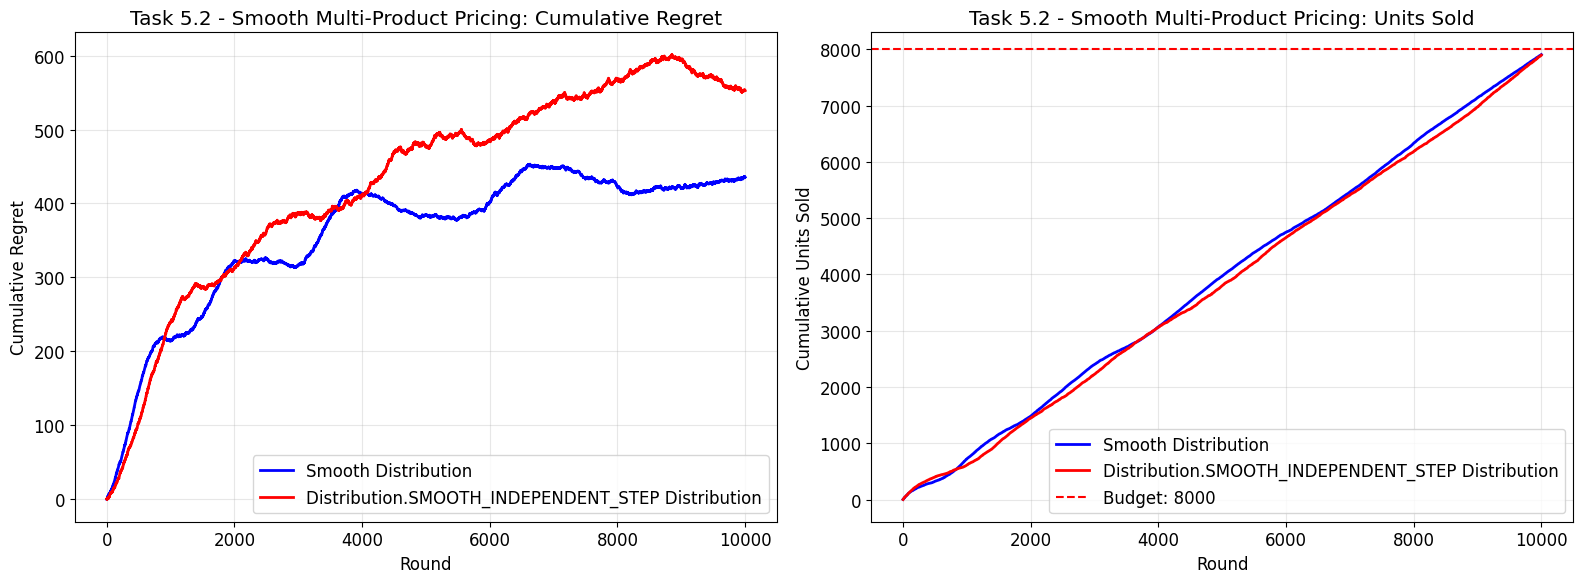


=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===

Plot per distribuzione Smooth:


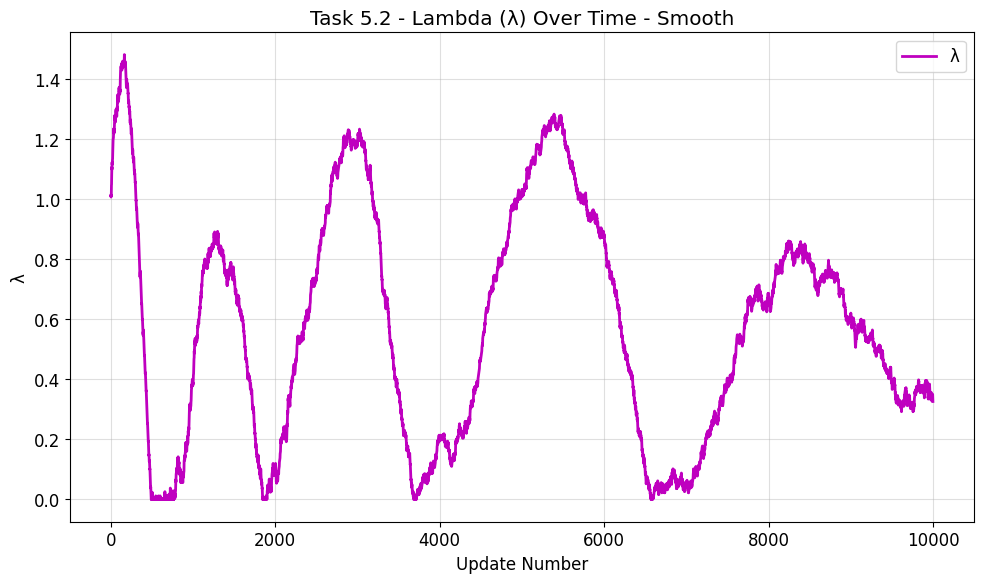

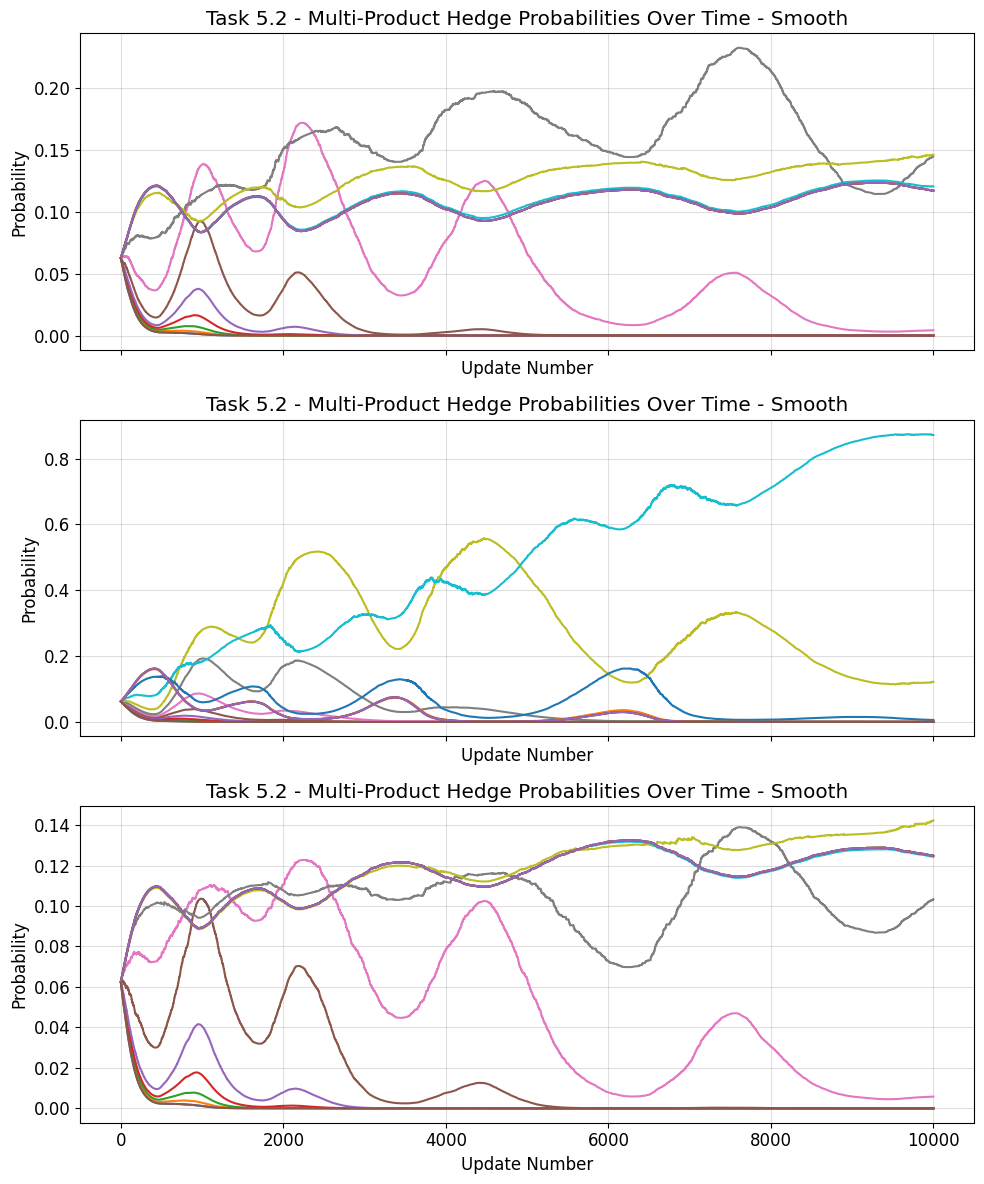


Plot per distribuzione Distribution.SMOOTH_INDEPENDENT_STEP:


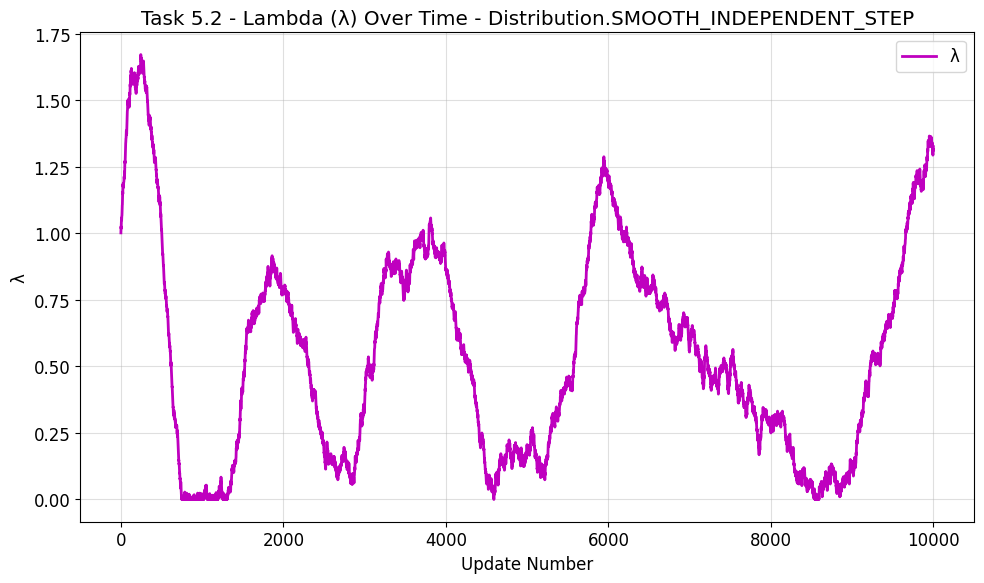

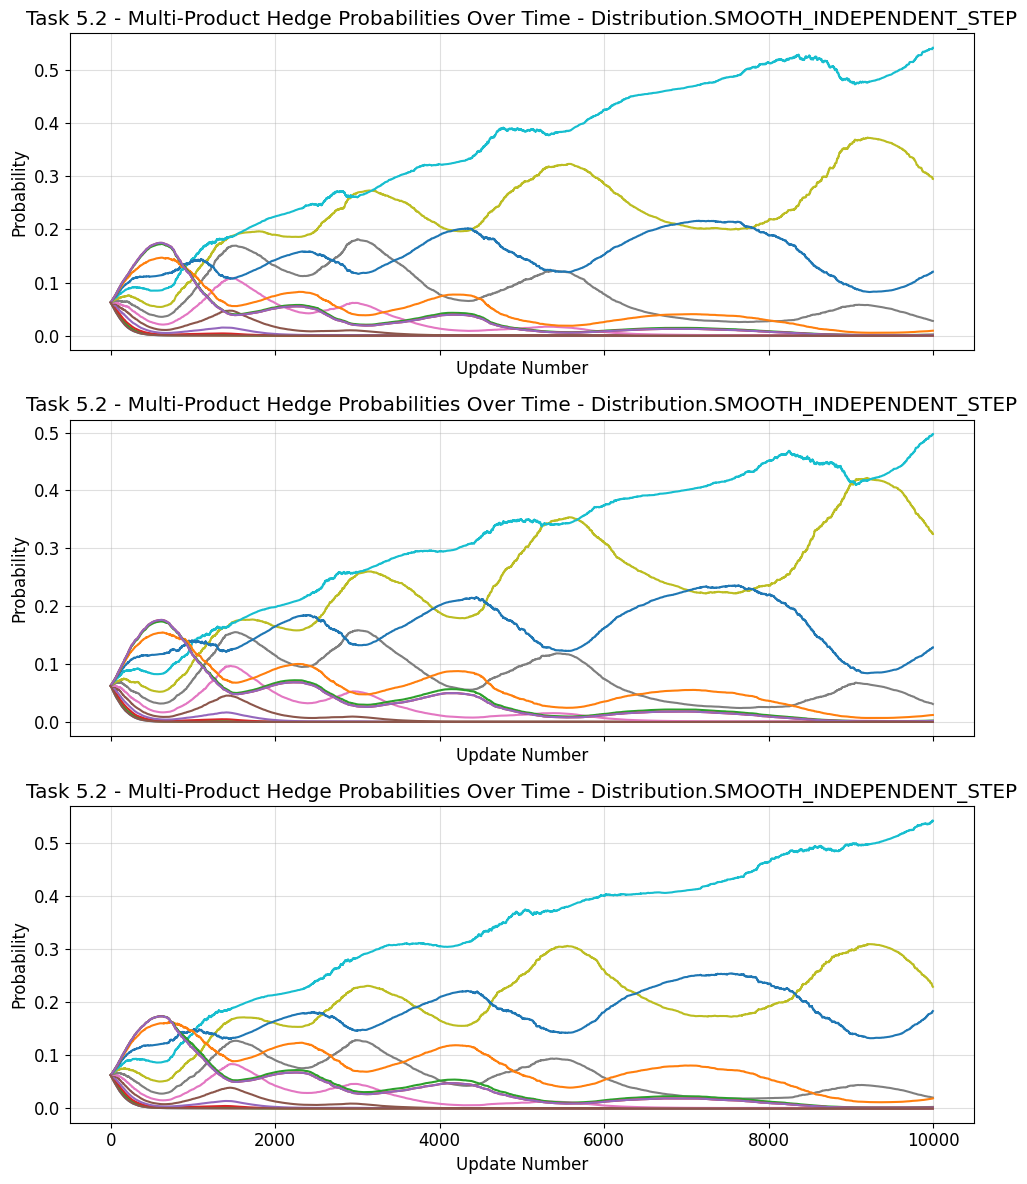

In [3]:
class Task5_2_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.N_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.N_products)
        ]
        self.num_windows = config.n_windows
        self.distribution = config.distribution
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, n_products=self.N_products, num_windows=self.num_windows, rng=rng, distribution=self.distribution
        )
        return self.env
        
    def create_agent(self):
        self.agent = MultiProductFFPrimalDualPricingAgent(
            self.price_grid, self.config.horizon, self.config.budget, 
            n_products = self.N_products, eta = 1 / np.sqrt(self.config.horizon)
        )
        return self.agent
        
    def compute_clairvoyant_reward(self) -> float:
        self.clair_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.env.valuations, self.price_grid[0], self.config.budget
        )
        return self.clair_reward
        
    def extract_metrics(self, result) -> Tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))
    
    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 5.2 with smooth valuation data"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        
        env = self.create_environment(trial_seed)
        agent = self.create_agent()
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0

        self.compute_clairvoyant_reward()

        
        print(f"Trial {trial+1}/{self.config.n_trials}...")
        
        for t in range(self.config.horizon):
            choice = agent.pull_arm()
            if choice is None or np.any([c is None for c in choice]):
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break
                
            rewards, costs, val = env.round(choice)
            
            agent.update(val)

            actual_rew = rewards.sum()
            actual_units = costs.sum()
            cum_reward += actual_rew
            
            instant_regret = self.clair_reward - actual_rew
            cum_regret += instant_regret
            cum_units += actual_units
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}")
        print(f"Trial {trial+1}: Budget used = {cum_units}/{self.config.budget} ({100*cum_units/self.config.budget:.1f}%)")
        if regrets is not None and len(regrets) > 0:
            regret_per_round = cum_regret / float(len(regrets))
            print(f"Trial {trial+1}: Final regret per round = {regret_per_round:.4f}")
        else:
            print(f"Trial {trial+1}: No regret data collected")
        
        return regrets, units_sold, cum_reward, agent


base_prices = np.linspace(0, 1, 15)
config = ExperimentConfig(
    task_name="Task 5.2 - Smooth Multi-Product Pricing",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=8_000,
    prices=base_prices,
    n_products=3,
    n_windows=4,
    distribution=[Distribution.SMOOTH_SIMILAR_STEP, Distribution.SMOOTH_INDEPENDENT_STEP]
)

print(f"Task 5.2 - Smooth Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: 4")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

multi_runner = MultiDistributionRunner(Task5_2_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True)

print(f"\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 5.2 - Lambda (λ) Over Time - {name}")
    
    StandardPlotter.plot_multi_hedge_probabilities(
        result.final_agents[0], 
        title=f"Task 5.2 - Multi-Product Hedge Probabilities Over Time - {name}")

# 5.3 Comparison with Primal Dual ExP3.P

Implementation of Primal-Dual Exp3.P for local adaptation to new window's distribution.

Task 5.3 - Smooth Multi-Product Pricing
Products: 3, Temporal windows: 4
Budget: 10000, Horizon: 10000
Prices per product: 16

=== Eseguendo esperimento con distribuzione Smooth ===
Running Task 5.3 - Smooth Multi-Product Pricing (Smooth)
Horizon: 10000, Trials: 1
Trial 1/1... Trial 1/1...
Expected utility: 0.5802
Optimal distribution (gamma): [[ 0.          0.          0.          0.          0.          0.
  -0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.36129954  0.63870046  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]
Expected cost: 1.0000
Trial 1: Budget exhausted at round 7392.
Trial 1: Final reward = 2486.64
Trial 1: 

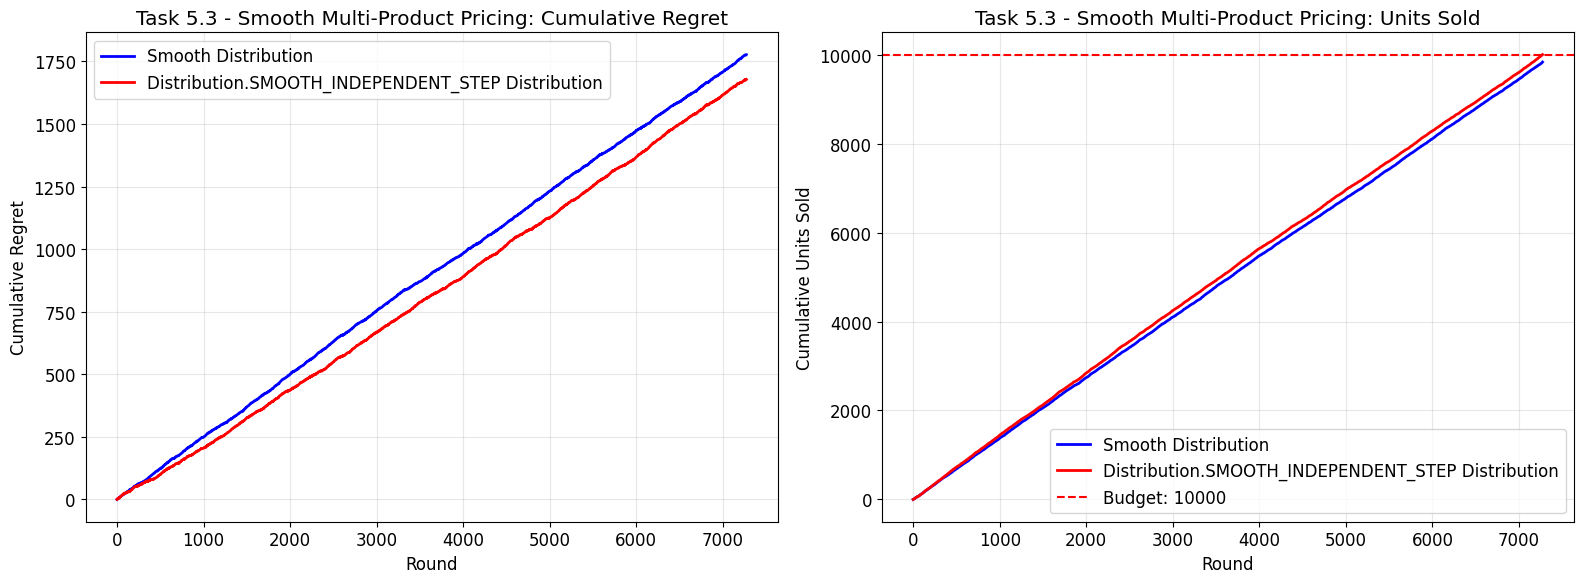


=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===

Plot per distribuzione Smooth:


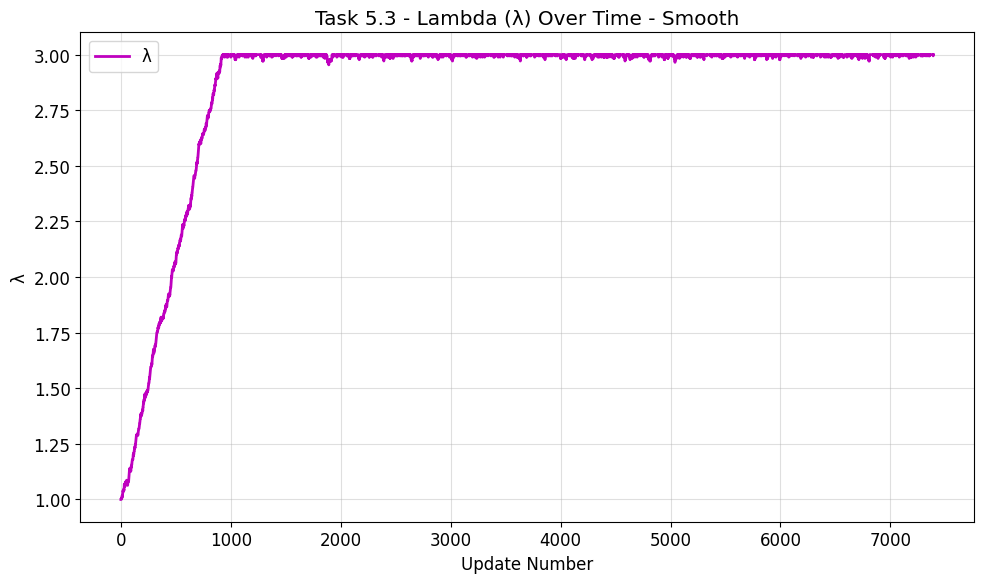

No hedge probability history recorded in the agent.

Plot per distribuzione Distribution.SMOOTH_INDEPENDENT_STEP:


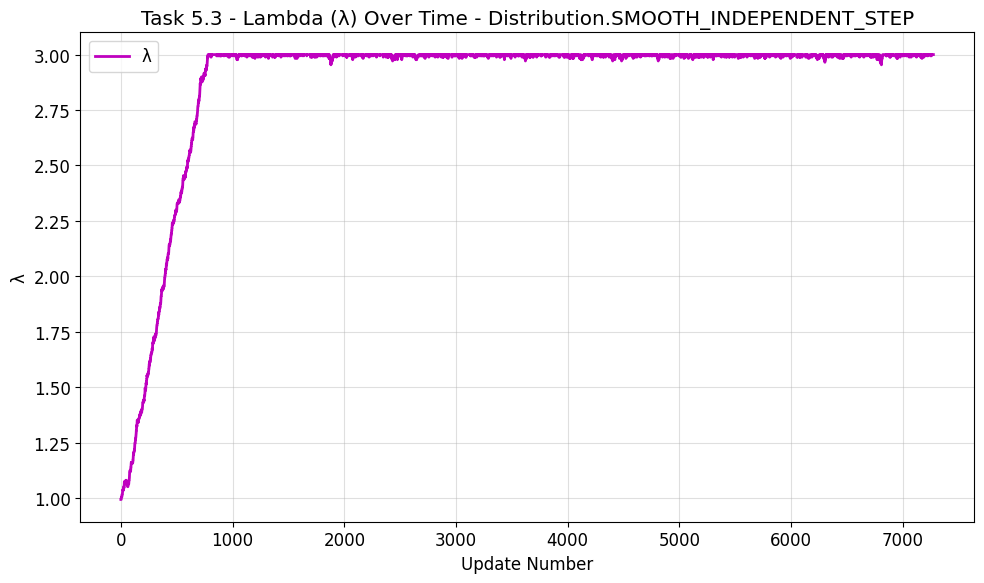

No hedge probability history recorded in the agent.

=== ANALISI DETTAGLIATA ===

--- Distribuzione Smooth ---

RESULTS FOR Task 5.3 - Smooth Multi-Product Pricing (Smooth)
Execution time: 0.97 seconds
Completed rounds: 7392
Average regret per round: 0.243813
Average final reward: 2486.64 ± 0.00
Efficiency vs clairvoyant: 58.0%
Average units sold: 10000.00/10000 (100.0%)

--- Distribuzione Distribution.SMOOTH_INDEPENDENT_STEP ---

RESULTS FOR Task 5.3 - Smooth Multi-Product Pricing (Distribution.SMOOTH_INDEPENDENT_STEP)
Execution time: 1.17 seconds
Completed rounds: 7274
Average regret per round: 0.230641
Average final reward: 2653.07 ± 0.00
Efficiency vs clairvoyant: 61.3%
Average units sold: 10000.00/10000 (100.0%)

=== CONFRONTO FINALE ===
Smooth: Final Average Regret = 1802.2640, Final Average Reward = 2486.6429
Distribution.SMOOTH_INDEPENDENT_STEP: Final Average Regret = 1677.6799, Final Average Reward = 2653.0714


In [4]:
class Task5_3_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.n_products)
        ]
        self.num_windows = config.n_windows
        self.window_size = int(
            (config.horizon * np.log(config.horizon)) ** (2/3))
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, n_products=self.n_products, num_windows=self.num_windows, rng=rng, distribution=self.distribution
        )
        return self.env

    def create_agent(self):
        self.agent = MultiProductPDExp3PricingAgent(
            self.price_grid, self.config.horizon, self.config.budget,
            n_products=self.n_products
        )
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        full_prices = self.price_grid[0]
        self.clair_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.env.valuations, full_prices, self.config.budget
        )
        return self.clair_reward

    def extract_metrics(self, result) -> Tuple[float, float]:
        rewards, costs, _ = result
        return float(np.sum(rewards)), float(np.sum(costs))

    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 5.3 with smooth valuation data"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)

        env = self.create_environment(trial_seed)
        agent = self.create_agent()

        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0

        print(f"Trial {trial+1}/{self.config.n_trials}...")
        self.compute_clairvoyant_reward()

        for t in range(self.config.horizon):
            choice = agent.pull_arm()
            if choice is None:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break

            rewards, costs, val = env.round(choice)
            agent.update(val)

            reward, cost = float(np.sum(rewards)), float(np.sum(costs))
            cum_reward += reward

            # Compute instantaneous regret
            instant_regret = self.clair_reward - reward
            cum_regret += instant_regret
            cum_units += cost
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}")
        print(
            f"Trial {trial+1}: Budget used = {cum_units}/{self.config.budget} ({100*cum_units/self.config.budget:.1f}%)")
        if len(regrets) > 0:
            regret_per_round = cum_regret / float(len(regrets))
            print(
                f"Trial {trial+1}: Final regret per round = {regret_per_round:.4f}")
        else:
            print(f"Trial {trial+1}: No regret data collected")

        return regrets, units_sold, cum_reward, agent


base_prices = np.linspace(0, 1, 15)

config = ExperimentConfig(
    task_name="Task 5.3 - Smooth Multi-Product Pricing",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=10_000,
    prices=base_prices,
    n_products=3,
    n_windows=4,
    distribution=[Distribution.SMOOTH_SIMILAR_STEP, Distribution.SMOOTH_INDEPENDENT_STEP]
)

print(f"Task 5.3 - Smooth Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: 4")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

multi_runner = MultiDistributionRunner(Task5_3_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True)

print(f"\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 5.3 - Lambda (λ) Over Time - {name}")
    
    StandardPlotter.plot_multi_hedge_probabilities(
        result.final_agents[0], 
        title=f"Task 5.3 - Multi-Product Hedge Probabilities Over Time - {name}")

multi_runner.print_analysis()